# HMM for Sleep Apnea Detection

## Introduction

Sleep apnea is a serious sleep disorder characterized by repeated interruptions in breathing during sleep. These interruptions, called apneas, can last from a few seconds to minutes, and they can occur hundreds of times throughout the night. Sleep apnea leads to increased risks of cardiovascular issues, cognitive impairment, daytime fatigue, and accidents. Early diagnosis and treatment, such as CPAP therapy, are crucial to mitigating these risks. However, traditional diagnostic methods are costly and time-consuming. Machine learning (ML) offers a promising solution by analyzing polysomnographic data, including ECG, EEG, and respiratory signals, to detect sleep apnea episodes early. By recognizing subtle patterns in these signals, ML models can provide accurate, real-time predictions, enabling timely intervention and personalized treatment. This approach reduces the risk of unforeseen health complications, improves diagnostic accuracy, and makes sleep apnea management more efficient and cost-effective. Additionally, Hidden Markov Models (HMM) are applied in this analysis, where sleep stages are treated as hidden states and ECG signals are used as observed inputs. The target values, including Hypopneas, Apneas, and No Apneas, allow the model to detect these events based on the transitions in sleep stages and heart rhythms, further enhancing detection accuracy and supporting more effective, personalized treatment strategies.

## Dataset Overview

The MIT-BIH Polysomnographic Database contains over 80 hours of polysomnographic recordings from patients monitored for sleep apnea and other sleep disorders. It includes multi-channel signals such as ECG, EEG, and respiratory data, annotated with sleep stages and apnea events. The dataset consists of 18 records, each containing four files: sleep/apnea annotations (.st), beat annotations (.ecg), signal data (.dat), and header information (.hea). This rich dataset is widely used for research and development of machine learning models aimed at improving the early detection and analysis of sleep apnea and related sleep disorders. For this analysis, only the ECG signals were used to detect sleep apnea events.

To prepare the data for analysis, the sleep study annotation files are parsed to extract and categorize sleep stages and apnea events over time. The annotations are mapped to specific sleep stages, such as Awake, Stage 1, Stage 2, Stage 3, Stage 4, and REM, while apnea events like apneas and hypopneas are identified and assigned accordingly. The parsed data is processed to ensure accurate tracking of stage transitions, filling any gaps in the stage information. The ECG signal records are then processed, and missing or unknown stages are handled through post-processing. This results in a comprehensive dataset that accurately reflects sleep patterns and apnea events for further analysis.

To process the annotations for event and sleep stage analysis, the annotation file is parsed to extract events and stages for the entire duration. The data is then divided into overlapping windows, where each window corresponds to a segment of the signal. For each window, the events and stages are identified, and the most frequent event and stage are selected based on their occurrence within the window. The process ensures that each window is classified with the most representative event and sleep stage, providing a windowed dataset that captures the temporal distribution of events and stages throughout the recording.

Butterworth bandpass filtering was applied with a cutoff frequency range of 0.5 to 50 Hz to effectively filter out unwanted noise from the ECG signal.

The features were extracted from the ECG windows to capture both statistical and frequency-domain characteristics of the signal. Here’s a concise explanation of each feature, including the event and sleep stage information:

- **mean**: The average value of the signal, helping to detect baseline shifts in the ECG signal.
- **variance**: Measures the variability of the signal, useful for detecting irregular heartbeats or arrhythmias.
- **skewness**: Quantifies the asymmetry of the signal distribution, highlighting abnormalities in heart rhythm.
- **kurtosis**: Indicates the "tailedness" or sharpness of the signal's distribution, helping identify extreme variations in heart activity.
- **shannon_entropy**: Measures the randomness or complexity of the signal, useful for assessing the regularity of heart rhythms.
- **zero_crossing**: Counts the number of times the signal crosses zero, useful for detecting rapid heart changes or anomalies.
- **peak_frequency**: Identifies the dominant frequency in the signal, helping to detect characteristic heart frequencies.
- **harmonic_ratio**: The ratio of harmonic components to the DC component in the FFT, revealing the rhythmic structure of the ECG.
- **heart_rate**: Calculated from the number of QRS peaks, directly measuring the number of heartbeats per minute.
- **event**: Describes the event associated with the window, categorized as:
  - **Hypopnea**: Partial airway blockage leading to shallow breathing.
  - **Apnea**: Complete airway blockage leading to cessation of breathing.
  - **No Apnea**: No significant breathing abnormalities detected (e.g., leg movements, arousals).
- **sleep_stage**: Provides the sleep or physiological stage associated with the window, with possible stages including:
  - **W (Wake)**: Awake state, typically corresponding to a more irregular heart pattern.
  - **1 (Stage 1)**: Light sleep, where heart rate and rhythm may begin to slow.
  - **2 (Stage 2)**: Deeper sleep with further slowing of the heart rate.
  - **3 (Stage 3)**: Deep sleep, characterized by more stable heart rhythms.
  - **4 (Stage 4)**: Another deep sleep phase with stable heart rhythms.
  - **R (REM)**: Rapid Eye Movement sleep, often associated with irregular heart rhythms due to dreaming and physiological activity.

These features are crucial for analyzing heart conditions and understanding the relationship between ECG patterns and events/stages in sleep, providing insights into cardiovascular health and sleep disorders.

In [1]:
## Importing all the necessary libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks, welch
import wfdb
from scipy.stats import skew, kurtosis
from typing import List, Dict, Tuple
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from scipy.fft import fft
from scipy.stats import entropy
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns


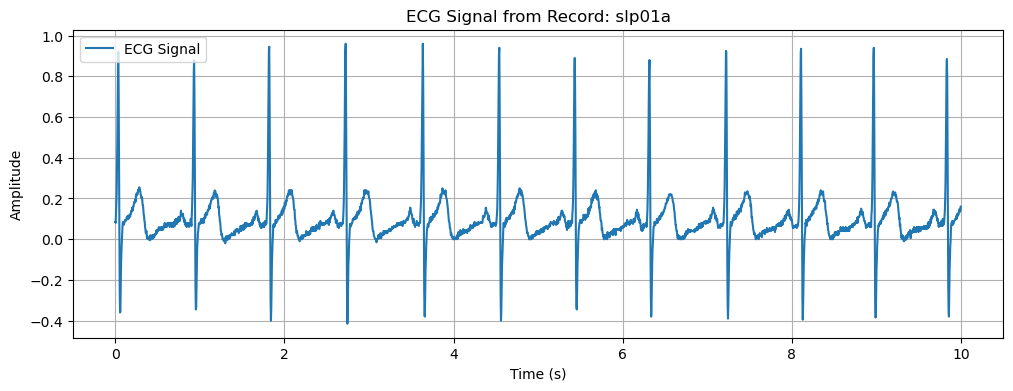

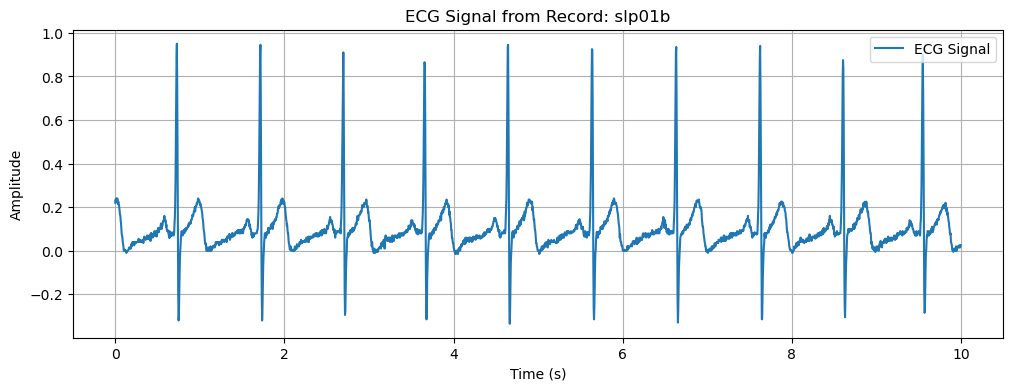

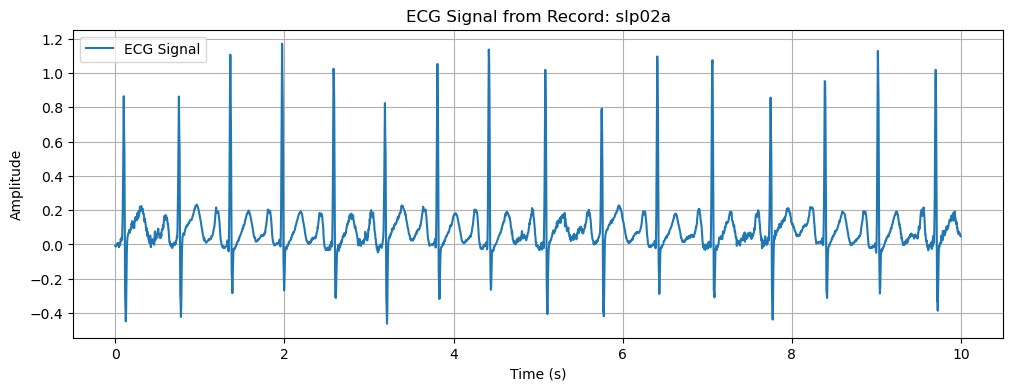

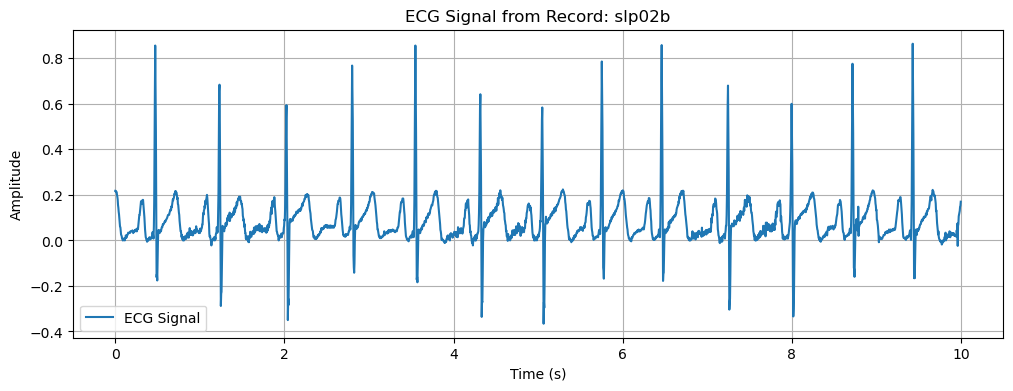

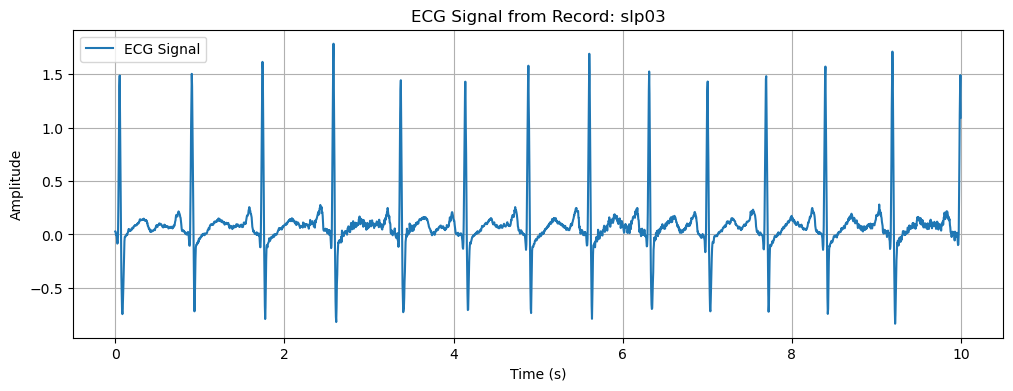

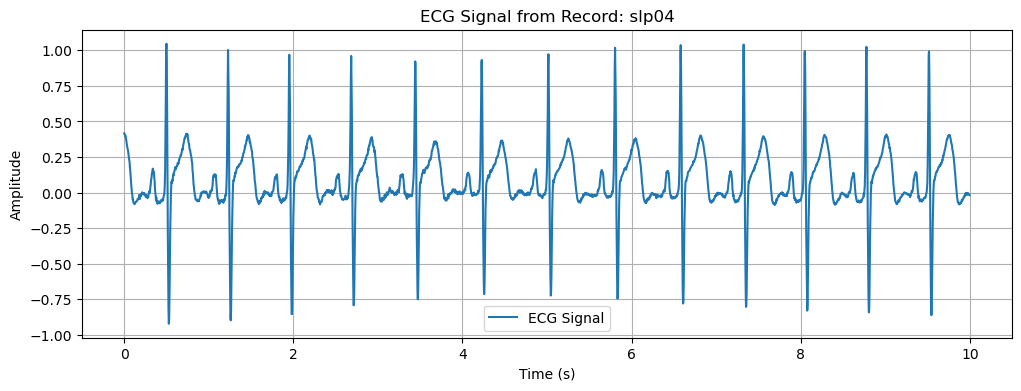

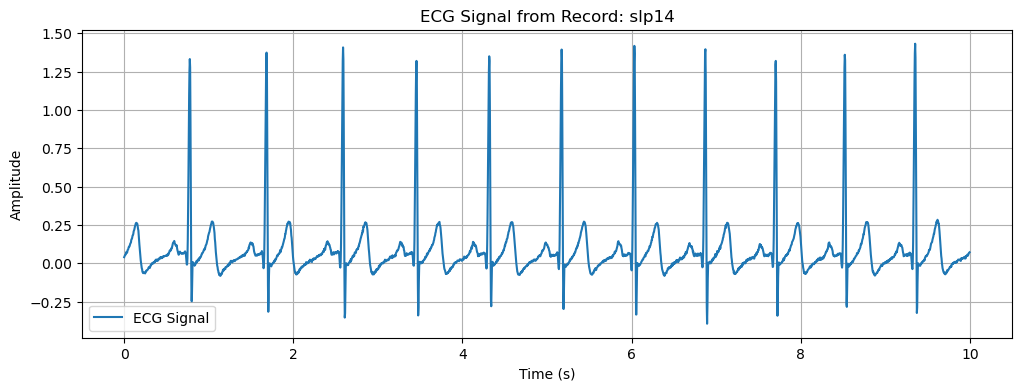

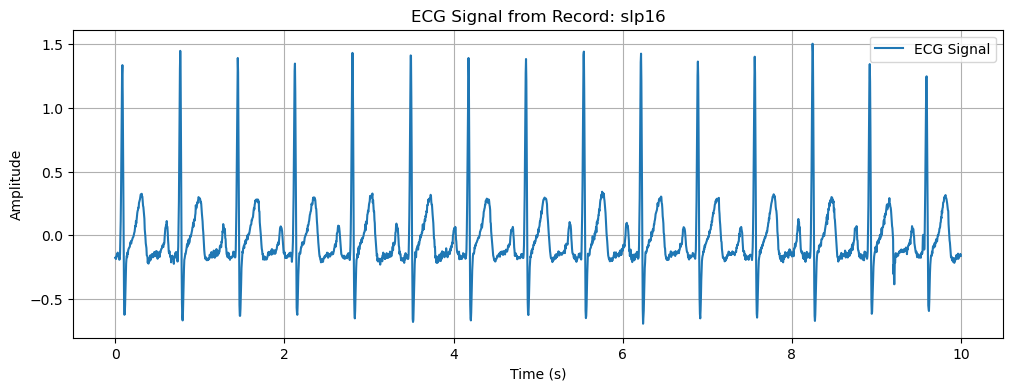

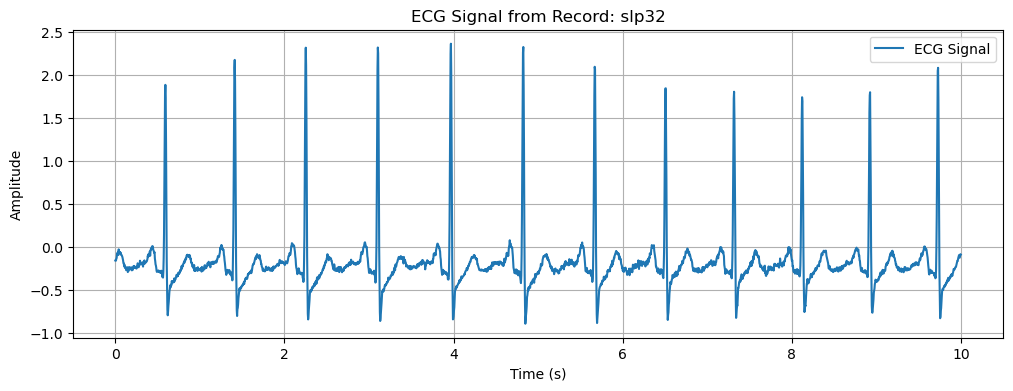

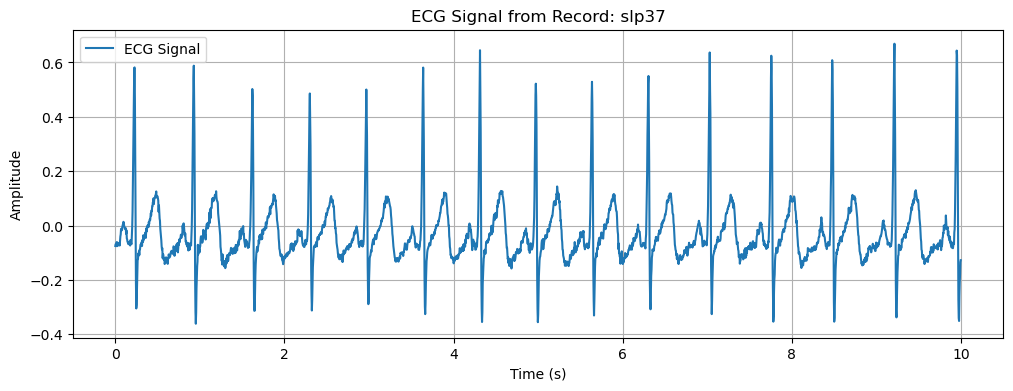

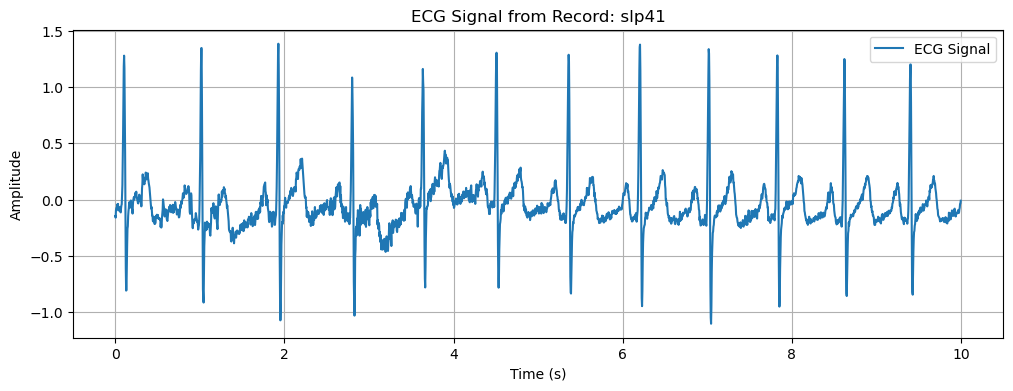

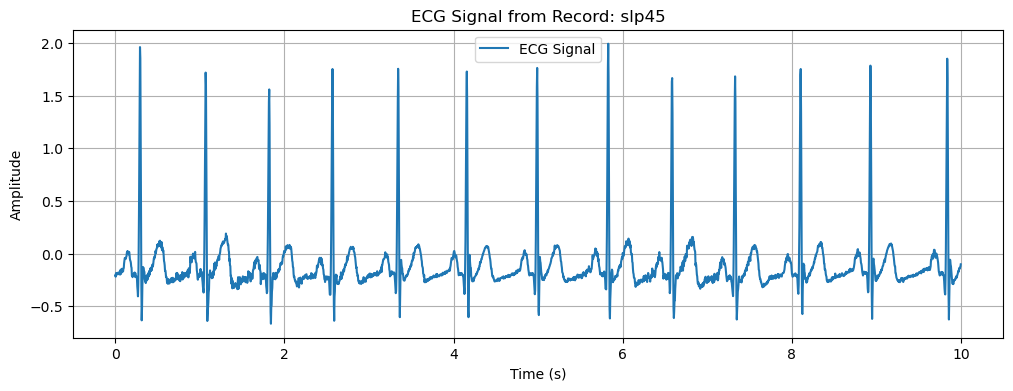

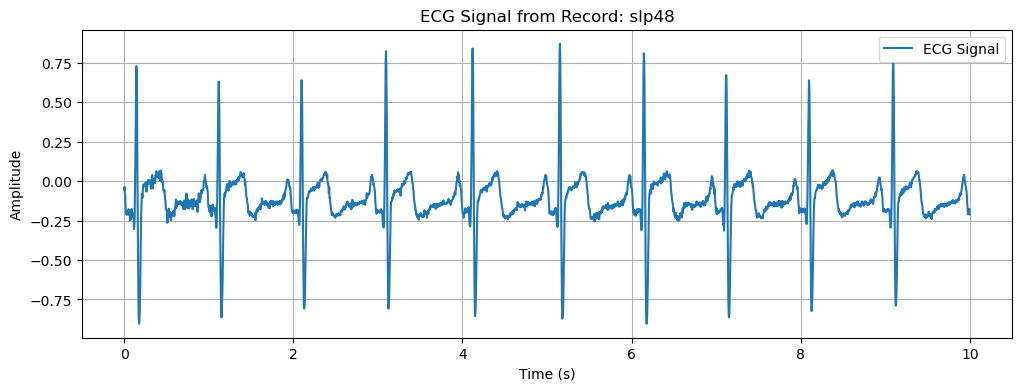

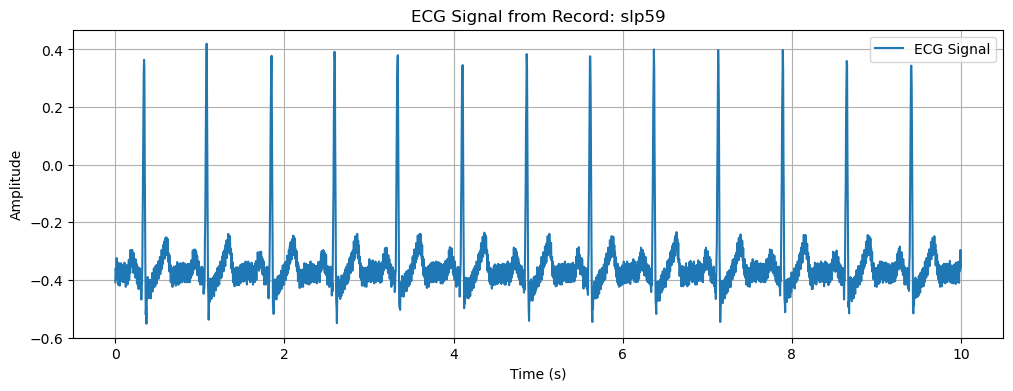

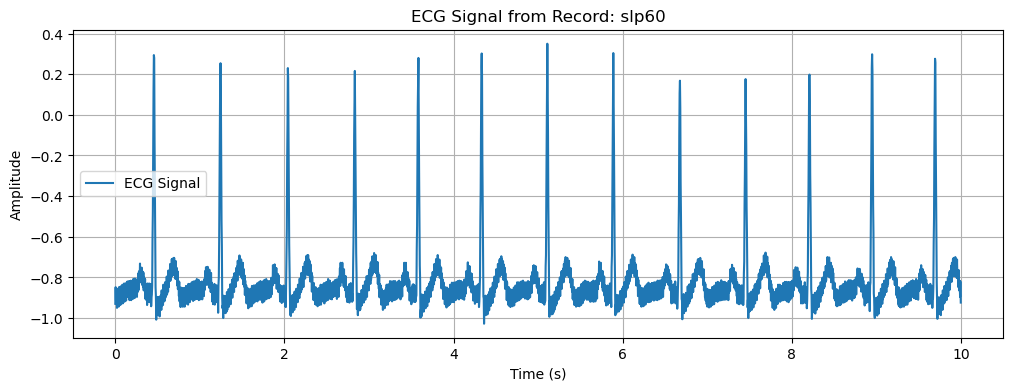

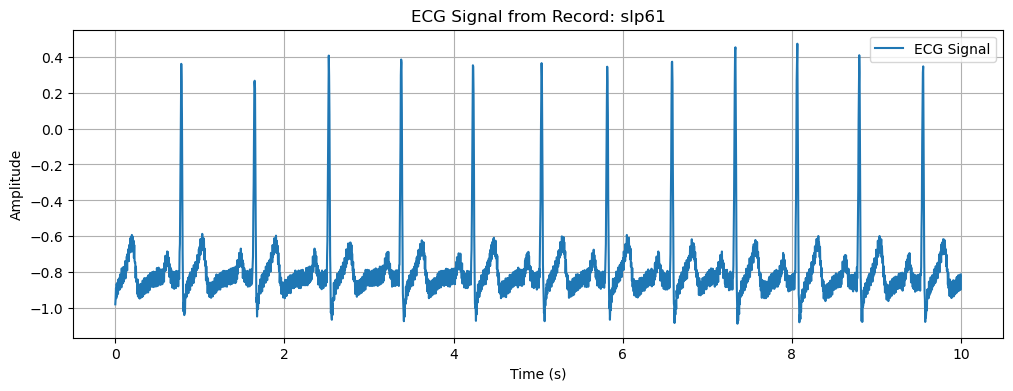

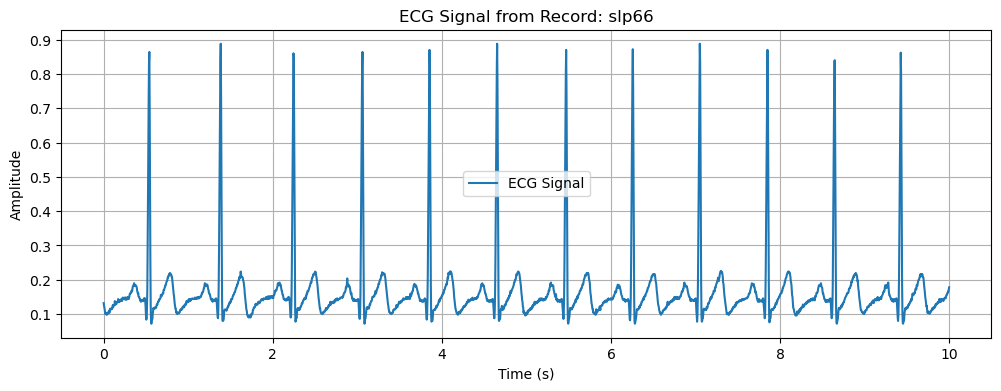

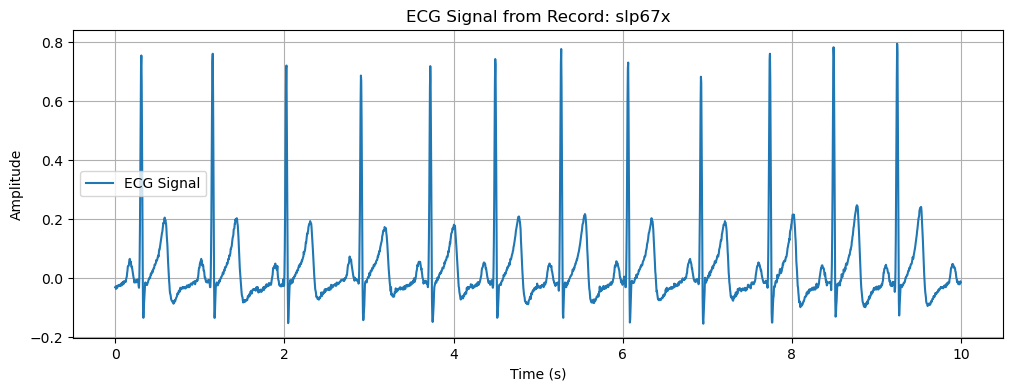

In [2]:
# Path to the data directory
data_path = "C:/Users/chand/OneDrive/Documents/Sleep Apnea/mit-bih-polysomnographic-database-1.0.0"

def plot_all_ecg(data_path, duration=10):
    """
    Plot the ECG signals from all available records in the database.

    Parameters:
    - data_path: Path to the folder containing the record files.
    - duration: Duration of the signal to display in seconds (default: 10 seconds).
    """
    # List all .dat files in the data path
    records = [file.replace('.dat', '') for file in os.listdir(data_path) if file.endswith('.dat')]

    if not records:
        print("No .dat files found in the specified directory.")
        return

    # Iterate through all records and plot the ECG signal
    for record_name in records:
        try:
            record_path = os.path.join(data_path, record_name)
            record = wfdb.rdrecord(record_path)

            # Sampling frequency
            fs = record.fs

            # Extract the ECG signal (it's the first signal)
            ecg_signal = record.p_signal[:, 0]

            # Calculate the number of samples to plot
            num_samples = int(fs * duration)
            signal_to_plot = ecg_signal[:num_samples]

            # Create a time vector
            time = [i / fs for i in range(num_samples)]

            # Plot the ECG signal
            plt.figure(figsize=(12, 4))
            plt.plot(time, signal_to_plot, label='ECG Signal')
            plt.title(f'ECG Signal from Record: {record_name}')
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')
            plt.legend()
            plt.grid()
            plt.show()
        
        except Exception as e:
            print(f"Error processing record {record_name}: {e}")

# Call the function to plot all ECG signals
plot_all_ecg(data_path, duration=10)


In [3]:
class SleepAnnotationParser:
    """Parser for sleep study annotation files with strict stage mapping"""
    def __init__(self):
        # Sleep stages mapping 
        self.sleep_stages = {
            'W': 'Awake', 
            '1': 'Stage 1', 
            '2': 'Stage 2',
            '3': 'Stage 3', 
            '4': 'Stage 4', 
            'R': 'REM'
        }

        # Event mapping 
        self.event_map = {
            'L': 'no apnea',
            'LA': 'no apnea', 
            'A': 'no apnea', 
            'MT': 'no apnea',
            'H': 'hypopneas',
            'HA': 'hypopneas',
            'OA': 'apneas',
            'X': 'apneas',
            'CA': 'apneas',
            'CAA': 'apneas'
        }

    def _parse_event_sequence(self, sequence: str) -> List[Tuple[str, str, bool]]:
        """
        Parse a sequence of events and sleep stages with strict stage checking
        """
        events = []
        current_pos = 0
        sequence = sequence.strip()
        sequence_length = len(sequence)
        current_stage = None
        
        while current_pos < sequence_length:
            try:
                current_char = sequence[current_pos]
                
                # Skip whitespace
                if current_char.isspace():
                    current_pos += 1
                    continue
                
                # Check for sleep stage
                if current_char in self.sleep_stages:
                    current_stage = self.sleep_stages[current_char]
                    events.append((None, current_stage, True))
                    current_pos += 1
                    continue
                
                # Try three-character events
                if current_pos + 3 <= sequence_length:
                    three_char = sequence[current_pos:current_pos + 3]
                    if three_char in self.event_map:
                        events.append((three_char, current_stage, False))
                        current_pos += 3
                        continue
                
                # Try two-character events
                if current_pos + 2 <= sequence_length:
                    two_char = sequence[current_pos:current_pos + 2]
                    if two_char in self.event_map:
                        events.append((two_char, current_stage, False))
                        current_pos += 2
                        continue
                
                # Try single-character events
                if current_char in self.event_map:
                    events.append((current_char, current_stage, False))
                    current_pos += 1
                else:
                    # Skip unrecognized character
                    current_pos += 1
                    
            except IndexError:
                break
                
        return events

    def parse_annotation_file(self, st_file: str, fs: int, duration: int) -> Tuple[np.ndarray, np.ndarray]:
        """Parse the annotation file with improved stage tracking"""
        events = np.full(duration, 'no apnea', dtype=object)
        stages = np.full(duration, 'Unknown', dtype=object)
        current_time = 0
        default_event_duration = int(fs * 5)  # 5 second default duration
        last_known_stage = None
        last_stage_time = 0
        
        try:
            if not os.path.exists(st_file):
                return events, stages
                
            with open(st_file, 'r', encoding='utf-8', errors='replace') as f:
                for line in f:
                    tokens = line.strip().split()
                    for token in tokens:
                        try:
                            # Try parsing as time value
                            time_value = float(token)
                            if last_known_stage is not None:
                                stages[last_stage_time:int(time_value * fs)] = last_known_stage
                            current_time = int(time_value * fs)
                            
                        except ValueError:
                            # Parse as event sequence
                            parsed_events = self._parse_event_sequence(token)
                            
                            for event_code, stage, is_stage_marker in parsed_events:
                                if current_time >= duration:
                                    continue
                                    
                                start_idx = current_time
                                end_idx = min(start_idx + default_event_duration, duration)
                                
                                # Handle events
                                if event_code is not None and event_code in self.event_map:
                                    events[start_idx:end_idx] = self.event_map[event_code]
                                
                                # Handle stages
                                if is_stage_marker and stage is not None:
                                    if last_known_stage is not None:
                                        stages[last_stage_time:start_idx] = last_known_stage
                                    stages[start_idx:end_idx] = stage
                                    last_known_stage = stage
                                    last_stage_time = end_idx
                                elif last_known_stage is not None:
                                    stages[start_idx:end_idx] = last_known_stage
                                    last_stage_time = end_idx
                                
                                current_time = end_idx
                
            # Fill remaining duration with last known stage
            if last_known_stage is not None and last_stage_time < duration:
                stages[last_stage_time:] = last_known_stage
                
        except Exception as e:
            print(f"Error parsing annotation file {st_file}: {str(e)}")
            
        return events, stages

def post_process_stages(stages: np.ndarray) -> np.ndarray:
    """
    Post-process stages to fill gaps between known stages
    """
    processed_stages = stages.copy()
    unknown_mask = (stages == 'Unknown')
    
    if np.any(unknown_mask):
        # Forward fill
        last_valid = None
        for i in range(len(stages)):
            if stages[i] != 'Unknown':
                last_valid = stages[i]
            elif last_valid is not None:
                processed_stages[i] = last_valid
        
        # Backward fill for any remaining unknowns
        last_valid = None
        for i in range(len(stages) - 1, -1, -1):
            if stages[i] != 'Unknown':
                last_valid = stages[i]
            elif last_valid is not None:
                processed_stages[i] = last_valid
    
    return processed_stages

def process_record(record_name: str, data_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Process a single record with stage statistics"""
    try:
        # Load record
        record = wfdb.rdrecord(os.path.join(data_path, record_name))
        signal_length = len(record.p_signal)
        
        # Parse annotations
        parser = SleepAnnotationParser()
        st_file = os.path.join(data_path, record_name + '.st')
        events, stages = parser.parse_annotation_file(st_file, record.fs, signal_length)
        
        # Post-process stages
        processed_stages = post_process_stages(stages)
        
        # Print stage distribution
        print(f"\nStage distribution for record {record_name}:")
        stage_counts = pd.Series(processed_stages).value_counts()
        print(stage_counts)
        
        return events, processed_stages
        
    except Exception as e:
        print(f"Error processing record {record_name}: {str(e)}")
        return np.array([]), np.array([])

In [4]:
def process_annotations(st_file: str, fs: int, window_size: int, overlap: float, total_duration: int) -> Tuple[np.ndarray, np.ndarray]:
    """Process annotations and return windowed events and sleep stages"""
    parser = SleepAnnotationParser()
    events, stages = parser.parse_annotation_file(st_file, fs, total_duration)
    window_samples = int(window_size * fs)
    step = int(window_samples * (1 - overlap))
    n_windows = (len(events) - window_samples) // step + 1
    windowed_events = np.full(n_windows, 'No Event', dtype=object)
    windowed_stages = np.full(n_windows, 'Unknown', dtype=object)
    for i in range(n_windows):
        start_idx = i * step
        end_idx = start_idx + window_samples
        window_events = events[start_idx:end_idx]
        unique_events, counts = np.unique(window_events, return_counts=True)
        event_mask = unique_events != 'No Event'
        if np.any(event_mask):
            unique_events = unique_events[event_mask]
            counts = counts[event_mask]
            windowed_events[i] = unique_events[np.argmax(counts)]
        window_stages = stages[start_idx:end_idx]
        unique_stages, counts = np.unique(window_stages, return_counts=True)
        stage_mask = unique_stages != 'Unknown'
        if np.any(stage_mask):
            unique_stages = unique_stages[stage_mask]
            counts = counts[stage_mask]
            windowed_stages[i] = unique_stages[np.argmax(counts)]
    return windowed_events, windowed_stages


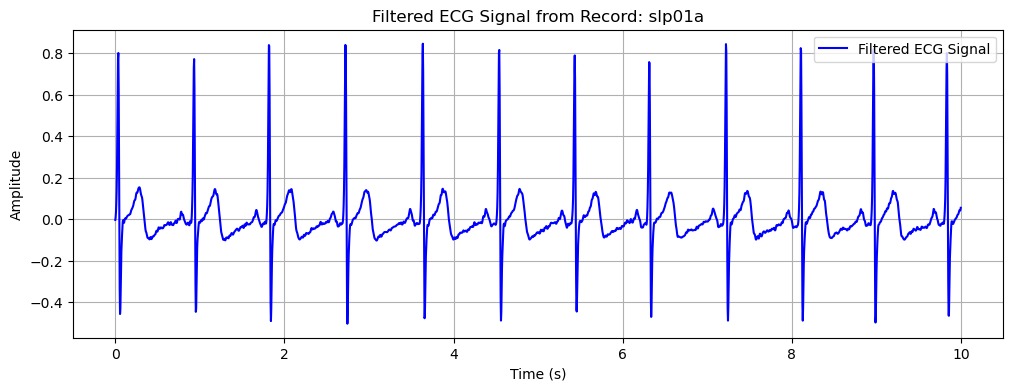

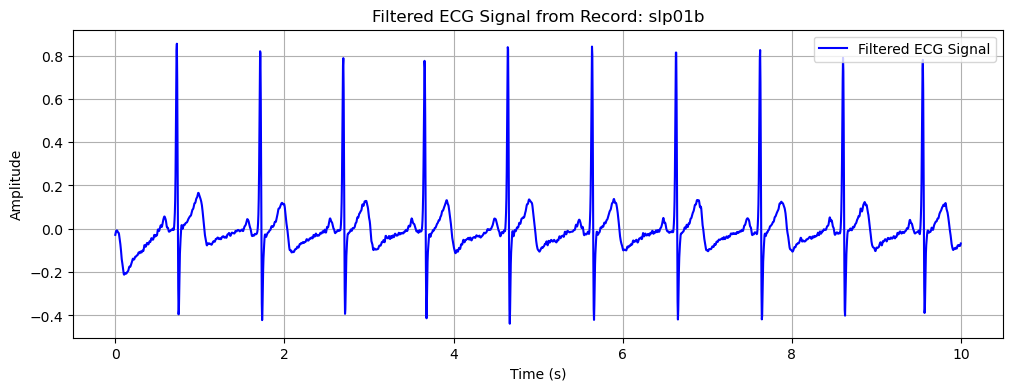

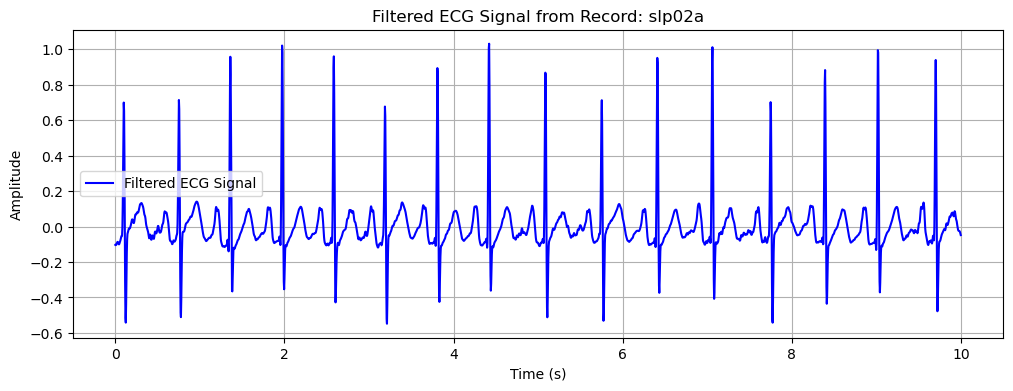

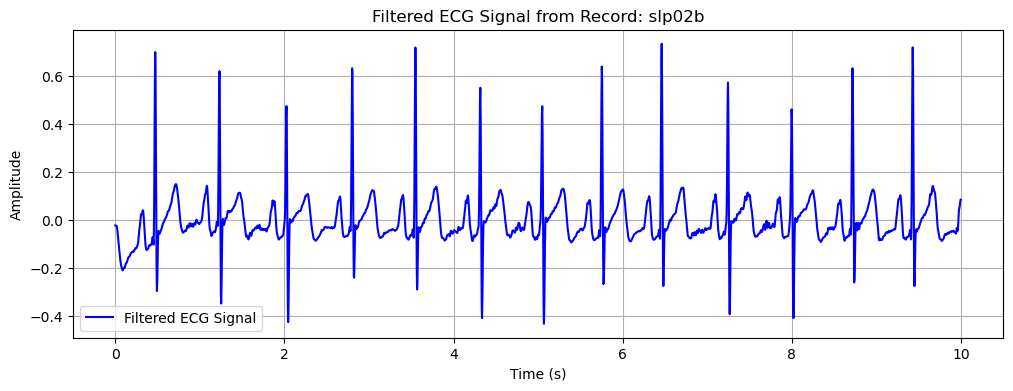

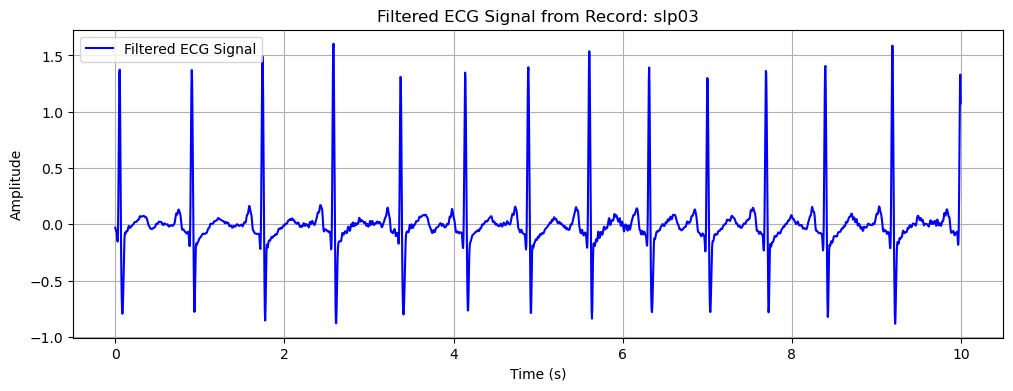

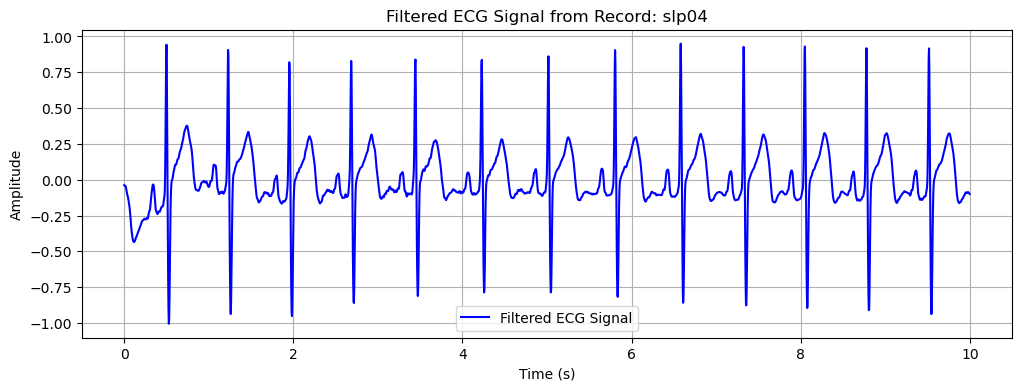

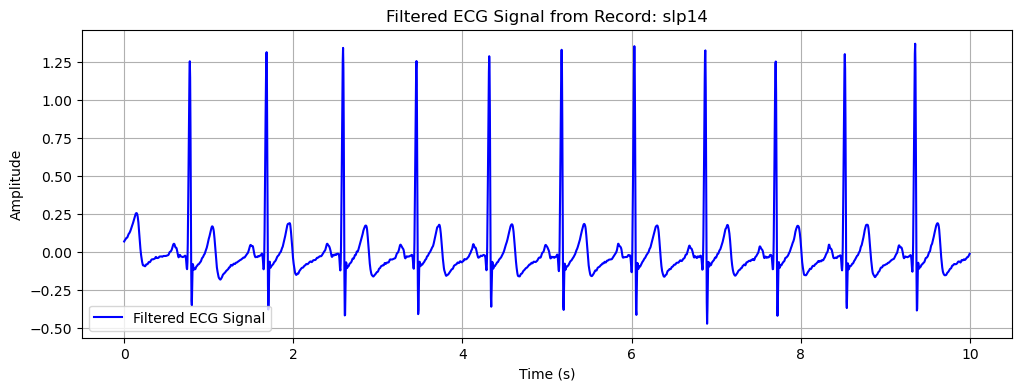

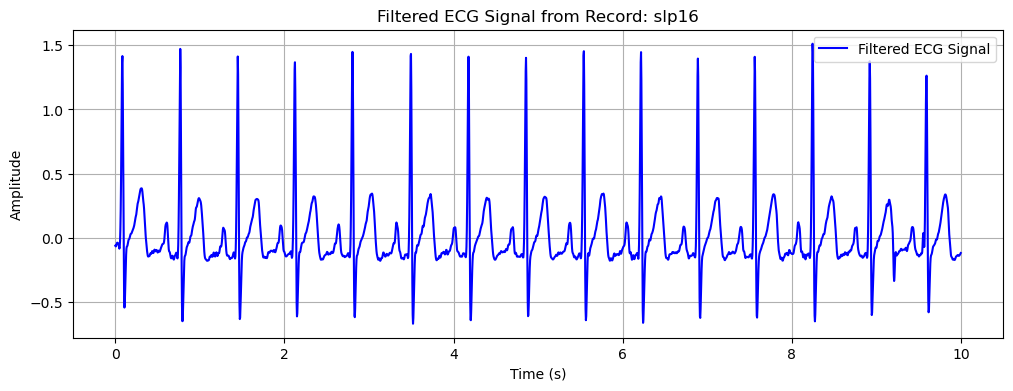

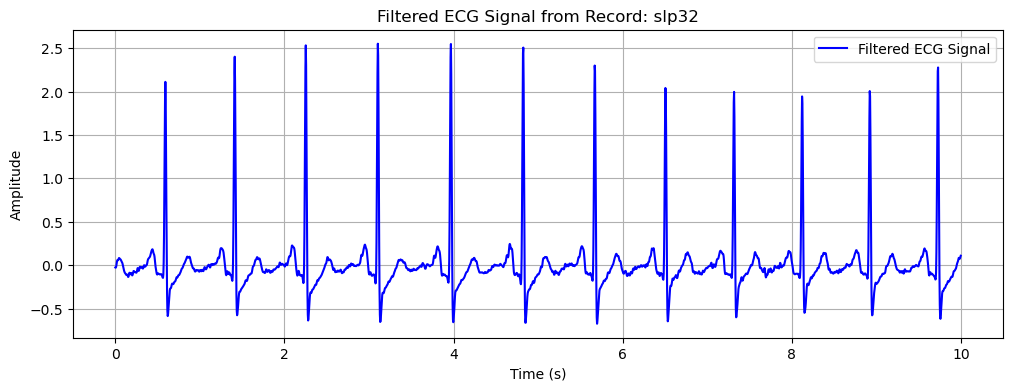

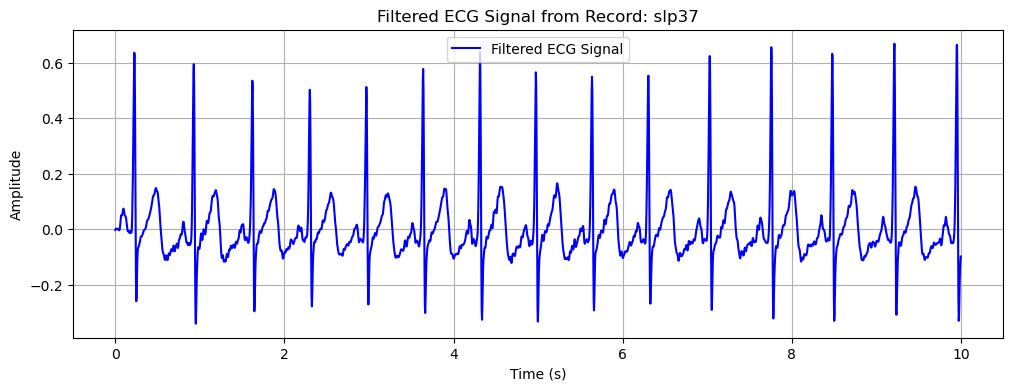

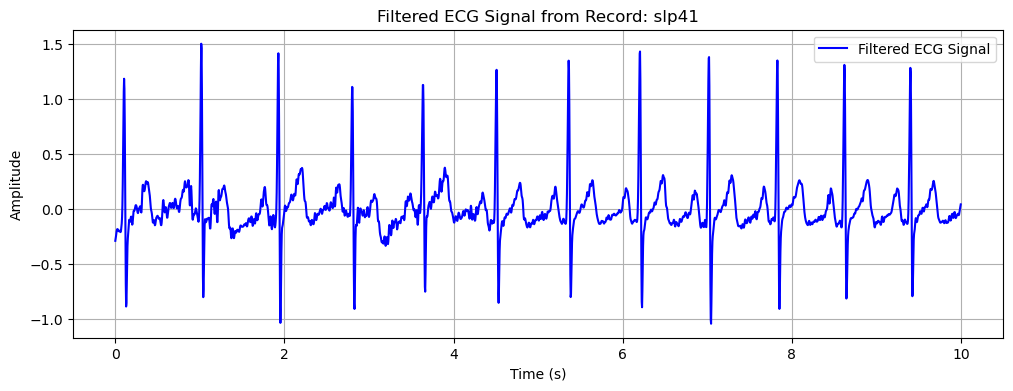

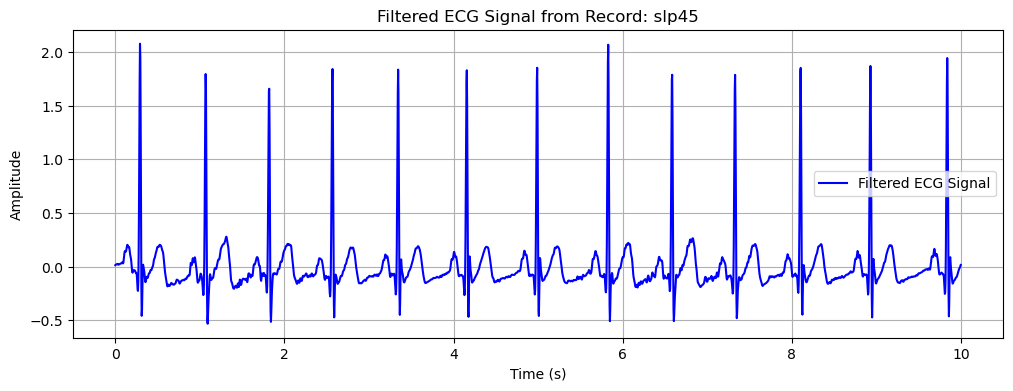

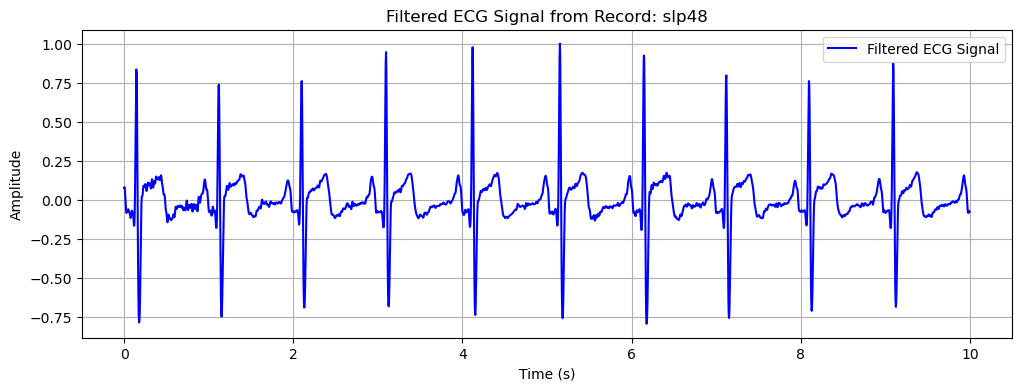

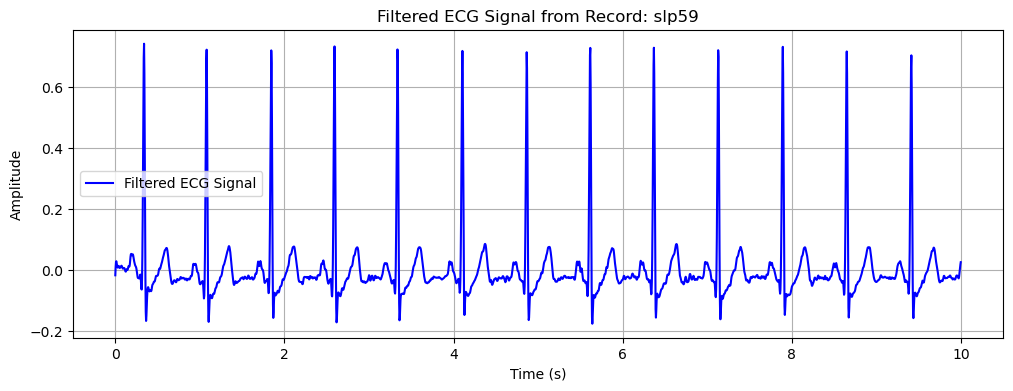

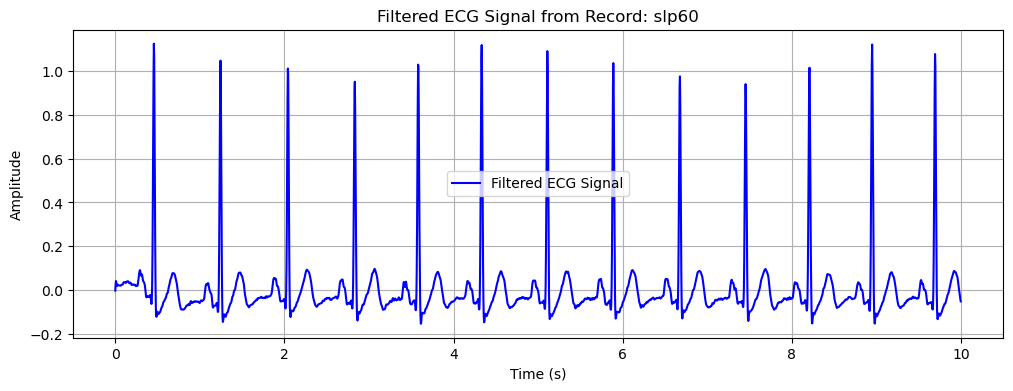

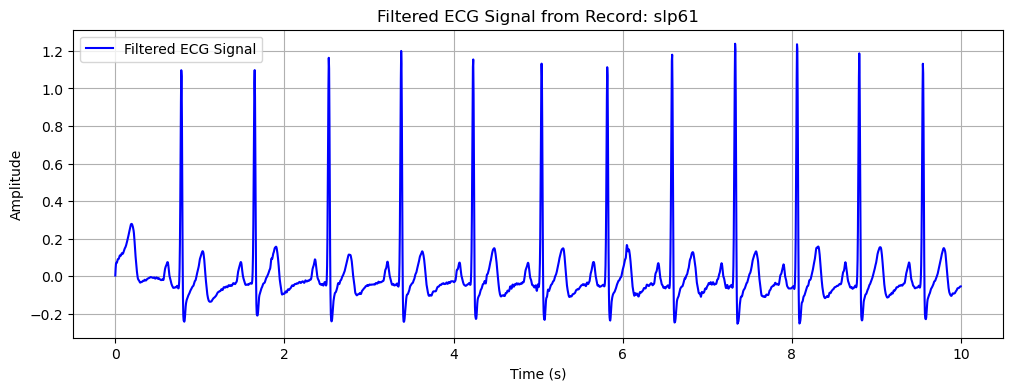

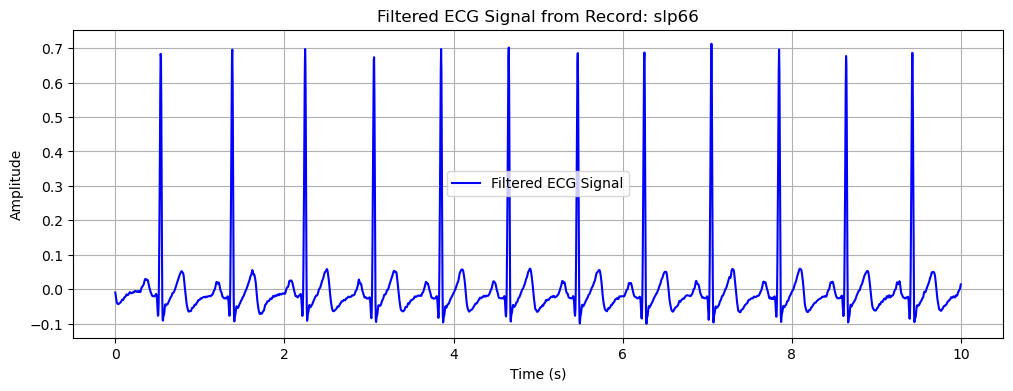

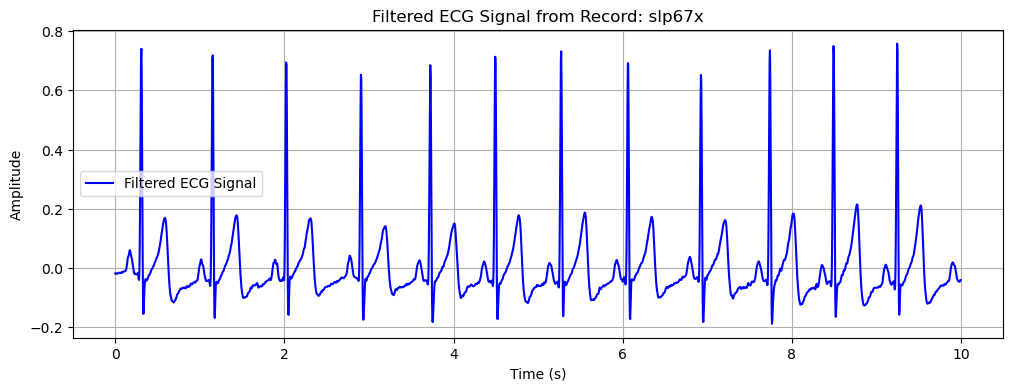

In [5]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Apply a Butterworth bandpass filter."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def plot_filtered_ecg(data_path, lowcut, highcut, duration=10, order=5):
    """
    Plot the filtered ECG signals from all available records in the database.

    Parameters:
    - data_path: Path to the folder containing the record files.
    - lowcut: Low cutoff frequency for the bandpass filter (Hz).
    - highcut: High cutoff frequency for the bandpass filter (Hz).
    - duration: Duration of the signal to display in seconds (default: 10 seconds).
    - order: Order of the Butterworth filter (default: 5).
    """
    # List all .dat files in the data path
    records = [file.replace('.dat', '') for file in os.listdir(data_path) if file.endswith('.dat')]

    if not records:
        print("No .dat files found in the specified directory.")
        return

    # Iterate through all records and plot the filtered ECG signal
    for record_name in records:
        try:
            record_path = os.path.join(data_path, record_name)
            record = wfdb.rdrecord(record_path)

            # Sampling frequency
            fs = record.fs

            # Extract the ECG signal (it's the first signal)
            ecg_signal = record.p_signal[:, 0]

            # Apply bandpass filter
            filtered_signal = butter_bandpass_filter(ecg_signal, lowcut, highcut, fs, order)

            # Calculate the number of samples to plot
            num_samples = int(fs * duration)
            signal_to_plot = filtered_signal[:num_samples]

            # Create a time vector
            time = np.linspace(0, duration, num_samples, endpoint=False)

            # Plot the filtered ECG signal
            plt.figure(figsize=(12, 4))
            plt.plot(time, signal_to_plot, label='Filtered ECG Signal', color='blue')
            plt.title(f'Filtered ECG Signal from Record: {record_name}')
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')
            plt.legend()
            plt.grid()
            plt.show()

        except Exception as e:
            print(f"Error processing record {record_name}: {e}")

# Parameters for the bandpass filter
lowcut = 0.5  # Low cutoff frequency in Hz
highcut = 50  # High cutoff frequency in Hz

# Call the function to process and plot filtered ECG signals
plot_filtered_ecg(data_path, lowcut, highcut, duration=10, order=5)


Butterworth bandpass filtering was applied with a cutoff frequency range of 0.5 to 50 Hz to effectively filter out unwanted noise from the ECG signal. The ECG data is filtered using the bandpass filter with adjustable low and high cutoff frequencies, and the filtered signal is plotted for a specified duration. This process helps in removing noise from the ECG signal and displaying the relevant portion for further analysis. The plot offers a clear visualization of the filtered ECG signal.

In [6]:
def segment_signal(signal, fs, window_size, overlap):
    """Segment the signal into windows."""
    window_samples = int(window_size * fs)
    step = int(window_samples * (1 - overlap))
    n_windows = (len(signal) - window_samples) // step + 1
    windows = [signal[i * step:i * step + window_samples] for i in range(n_windows)]
    return np.array(windows)


In [7]:
def extract_features(windows, fs, windowed_events, windowed_stages):
    """Extract features from the ECG windows and include events and stages."""
    features = []
    
    for i, window in enumerate(windows):
        mean = np.mean(window)
        variance = np.var(window)
        skewness = skew(window)
        kurt = kurtosis(window)
        
        # Shannon Entropy
        shannon_entropy = entropy(np.histogram(window, bins=256, range=(0, 1))[0])
        
        # Zero-Crossing Rate
        zero_crossings = np.count_nonzero(np.diff(np.sign(window)))
        
        # Peak Frequency
        f, Pxx = welch(window, fs)
        peak_freq = f[np.argmax(Pxx)]
        
        # Harmonic Ratio (using FFT to get the frequency components)
        fft_values = np.abs(fft(window))
        harmonic_ratio = np.sum(fft_values[1:]) / fft_values[0] if fft_values[0] != 0 else 0
        
        # Heart Rate (for ECG, heart rate is generally the frequency of peaks in the signal)
        qrs_indices, _ = find_peaks(window)
        heart_rate = len(qrs_indices) / len(window) * fs * 60  # beats per minute (bpm)
        
        event = windowed_events[i]
        stage = windowed_stages[i]
        
        # Collect all the features
        rounded_features = np.round([mean, variance, skewness, kurt, shannon_entropy, zero_crossings, peak_freq, harmonic_ratio, heart_rate], 4)
        
        # Append rounded features with event and stage
        features.append([*rounded_features, event, stage])
    
    return np.array(features)


In [8]:
def load_and_process_record(record_name):
    """Load the record, process the ECG signal, and include sleep stages and events."""
    record = wfdb.rdrecord(os.path.join(data_path, record_name))
    fs = record.fs
    ecg_signal = record.p_signal[:, 0]
    filtered_signal = butter_bandpass_filter(ecg_signal, 0.5, 50, fs)
    window_size = 30
    overlap = 0.5
    windows = segment_signal(filtered_signal, fs, window_size, overlap)
    st_file = os.path.join(data_path, record_name + '.st')
    total_duration = len(ecg_signal)
    windowed_events, windowed_stages = process_annotations(st_file, fs, window_size, overlap, total_duration)
    features = extract_features(windows, fs, windowed_events, windowed_stages)
    return features


In [9]:
# Main execution: process all records in the dataset
all_features = []
data_path = "C:/Users/chand/OneDrive/Documents/Sleep Apnea/mit-bih-polysomnographic-database-1.0.0"  

# Loop through files in the directory and process .dat files
for file in os.listdir(data_path):
    if file.endswith('.dat'):
        record_name = file.replace('.dat', '')
        features = load_and_process_record(record_name)  # Function loads and processes data
        all_features.append(features)

# Convert the results into a single array for further analysis
all_features = np.concatenate(all_features, axis=0)

# Define column names based on the new features
df_features = pd.DataFrame(all_features, columns=['mean', 'variance', 'skewness', 'kurtosis', 
                                                  'shannon_entropy', 'zero_crossings', 'peak_freq', 
                                                  'harmonic_ratio', 'heart_rate', 'event', 'sleep_stage'])

# Save features to CSV for analysis
df_features.to_csv('processed_features_with_annotations.csv', index=False)



In [10]:
df_features.head()

mean variance skewness kurtosis shannon_entropy zero_crossings  \
0   0.0002   0.0173   2.6112  16.3808          3.9089          222.0   
1  -0.0001   0.0167   2.6681  16.8918          3.9066          212.0   
2   0.0005   0.0172   2.6218   16.302          3.9421          210.0   
3      0.0   0.0172   2.6072  16.2717          3.9467          209.0   
4  -0.0005   0.0166   2.6814  16.9959          3.9071          217.0   

  peak_freq harmonic_ratio heart_rate     event sleep_stage  
0    0.9766     22696.7728     1430.0  no apnea     Stage 4  
1    0.9766     62277.8017     1424.0  no apnea     Stage 4  
2    0.9766     10556.7991     1396.0  no apnea     Stage 4  
3    0.9766    147492.9419     1426.0  no apnea     Stage 4  
4    0.9766      9219.8231     1472.0  no apnea     Stage 4

In [11]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20530 entries, 0 to 20529
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mean             20530 non-null  object
 1   variance         20530 non-null  object
 2   skewness         20530 non-null  object
 3   kurtosis         20530 non-null  object
 4   shannon_entropy  20530 non-null  object
 5   zero_crossings   20530 non-null  object
 6   peak_freq        20530 non-null  object
 7   harmonic_ratio   20530 non-null  object
 8   heart_rate       20530 non-null  object
 9   event            20530 non-null  object
 10  sleep_stage      20530 non-null  object
dtypes: object(11)
memory usage: 1.7+ MB


In [12]:
# Convert the object columns to numeric types
df_features[['mean', 'variance', 'skewness', 'kurtosis', 'shannon_entropy', 'zero_crossings', 
             'peak_freq', 'harmonic_ratio', 'heart_rate']] = df_features[['mean', 'variance', 
                                                                         'skewness', 'kurtosis', 
                                                                         'shannon_entropy', 'zero_crossings', 
                                                                         'peak_freq', 'harmonic_ratio', 
                                                                         'heart_rate']].apply(pd.to_numeric)



# Check the types again
print(df_features.dtypes)

mean               float64
variance           float64
skewness           float64
kurtosis           float64
shannon_entropy    float64
zero_crossings     float64
peak_freq          float64
harmonic_ratio     float64
heart_rate         float64
event               object
sleep_stage         object
dtype: object


The variables, initially in object format, were successfully converted to numeric types 

In [13]:
df_features.shape

(20530, 11)

In [14]:
# Check for null values
null_values = df_features.isnull().sum()
print("Null Values in Each Column:\n", null_values)

# Check for duplicates
duplicate_count = df_features.duplicated().sum()
print("\nNumber of Duplicate Rows:", duplicate_count)

# Remove duplicates if necessary
if duplicate_count > 0:
    df_features = df_features.drop_duplicates()
    print("\nDuplicates removed. New count:", df_features.shape[0])

Null Values in Each Column:
 mean               0
variance           0
skewness           0
kurtosis           0
shannon_entropy    0
zero_crossings     0
peak_freq          0
harmonic_ratio     0
heart_rate         0
event              0
sleep_stage        0
dtype: int64

Number of Duplicate Rows: 0


In [15]:
df_features.describe()

mean      variance      skewness      kurtosis  \
count  2.053000e+04  20530.000000  20530.000000  20530.000000   
mean   3.214808e-07      0.030997      2.799298     17.022940   
std    3.703801e-04      0.030991      1.753428      7.932799   
min   -6.200000e-03      0.000000     -3.467500     -0.141800   
25%   -2.000000e-04      0.014400      1.674100     10.734175   
50%   -0.000000e+00      0.027900      2.884150     17.567800   
75%    2.000000e-04      0.038600      4.425625     23.965675   
max    7.000000e-03      1.543300     12.033200    201.272700   

       shannon_entropy  zero_crossings     peak_freq  harmonic_ratio  \
count     20530.000000    20530.000000  20530.000000    2.053000e+04   
mean          4.003240      282.010765      4.870096    1.998975e+05   
std           0.386203      119.554450      3.332292    3.893557e+06   
min           0.260400      166.000000      0.976600    5.328635e+02   
25%           3.798025      211.000000      2.929700    1.570211e+04   
50%           3.999100      240.000000      3.906200    2.973524e+04   
75%           4.234475      305.000000      6.835900    7.221710e+04   
max           5.437800     1688.000000     37.109400    4.397989e+08   

         heart_rate  
count  20530.000000  
mean    1259.103069  
std      239.757535  
min      610.000000  
25%     1108.000000  
50%     1232.000000  
75%     1386.000000  
max     2248.000000

In [16]:
# Count the occurrences of each unique item in the 'event' column
print("Count of each unique item in 'event':")
print(df_features['event'].value_counts())

# Count the occurrences of each unique item in the 'sleep_stage' column
print("\nCount of each unique item in 'sleep_stage':")
print(df_features['sleep_stage'].value_counts())


Count of each unique item in 'event':
event
no apnea     17400
apneas        3115
hypopneas       15
Name: count, dtype: int64

Count of each unique item in 'sleep_stage':
sleep_stage
Awake      8127
Stage 2    6804
Stage 1    3462
REM        1430
Stage 3     503
Stage 4     204
Name: count, dtype: int64


The event data shows a dominant occurrence of "Hypopnea" (17400 counts), with very few occurrences of "Apnea" (15 counts), while the sleep stage data indicates the highest frequency in stage 0 (Wake) and stage 3 (Deep sleep), with fewer occurrences in stages 4 (Stage 4) and 5 (REM).

## Univariate Analysis

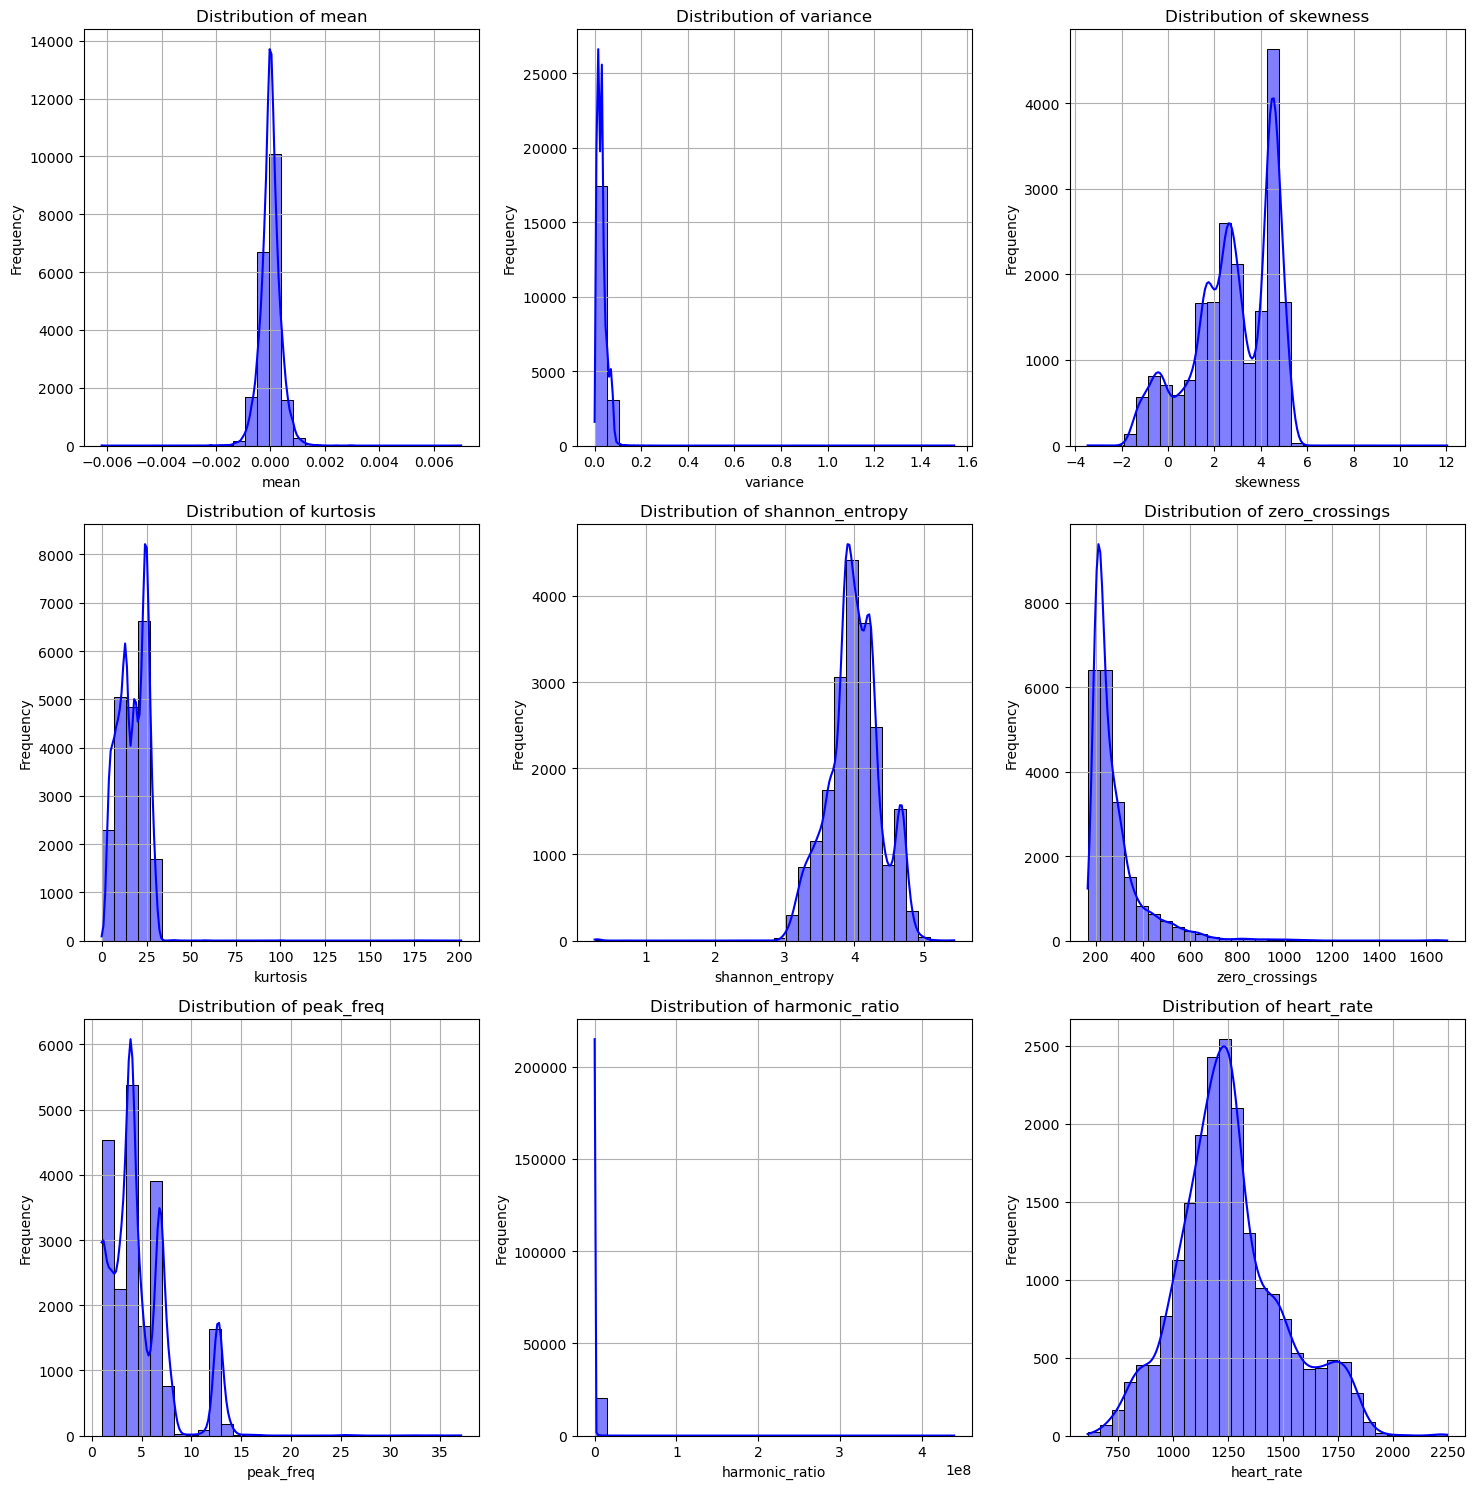

In [17]:
def univariate_analysis_numerical(df):
    """Perform univariate analysis for numerical features with a 3x3 grid layout, and save the plots."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    import math

    numerical_columns = df.select_dtypes(include=['float64']).columns
    num_rows = math.ceil(len(numerical_columns) / 3)
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    for i, col in enumerate(numerical_columns):
        sns.histplot(df[col], kde=True, bins=30, ax=axes[i], color='blue')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].grid()
        # Save each plot
        fig.savefig(f'distribution_{col}.png')

    # Turn off unused subplots
    for i in range(len(numerical_columns), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
univariate_analysis_numerical(df_features)

The distributions shown in these histograms reveal distinct patterns across different features: the mean and variance show sharp, concentrated peaks indicating little variation in these metrics, while skewness exhibits a multimodal distribution suggesting multiple distinct patterns in the data's asymmetry. The kurtosis distribution is heavily right-skewed with multiple peaks at lower values, Shannon entropy shows a roughly normal distribution with some secondary peaks, and zero_crossings has a sharp primary peak with a long right tail. The peak frequency distribution shows multiple distinct peaks suggesting common frequency bands in the data, while the harmonic ratio is extremely concentrated near zero. Most notably, the heart rate distribution appears approximately normal with a slight right skew, centered around 1250-1500, suggesting a relatively consistent range of heart rates in the dataset with some higher outliers.

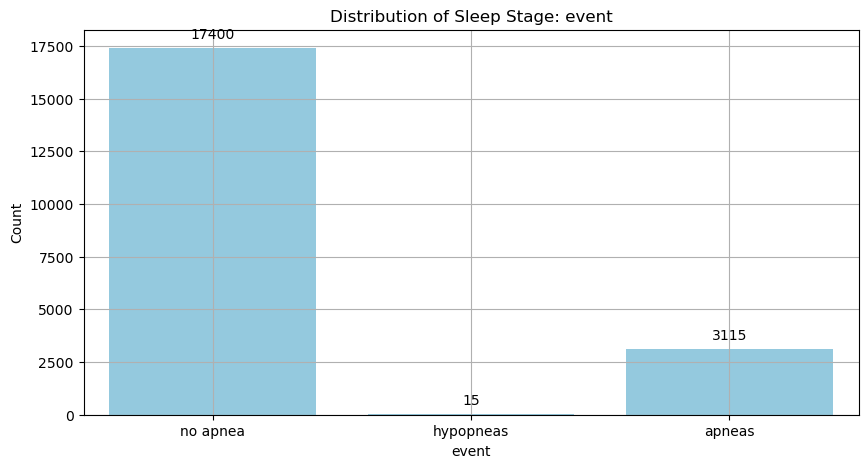

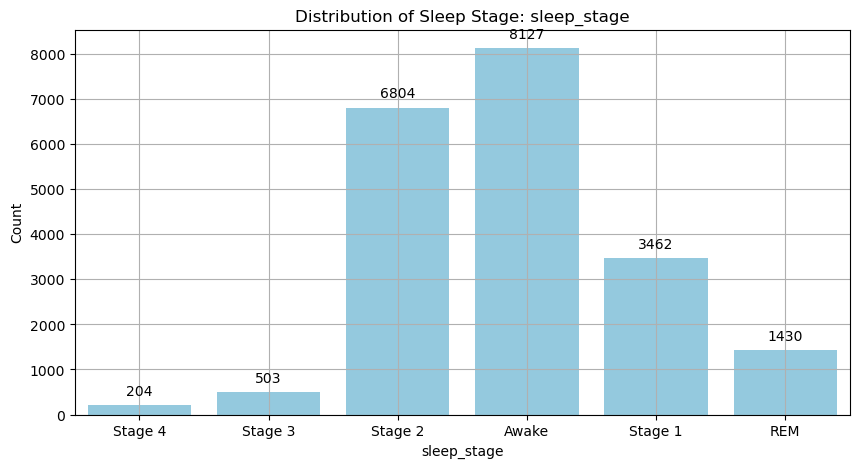

In [18]:
def univariate_analysis_sleep_stages(df):
    """Perform univariate analysis for sleep stage categorical features and save the plots."""
    import matplotlib.pyplot as plt
    import seaborn as sns

    sleep_stage_columns = df.select_dtypes(include=['object']).columns

    for col in sleep_stage_columns:
        plt.figure(figsize=(10, 5))
        ax = sns.countplot(data=df, x=col, color="skyblue")  
        plt.title(f'Distribution of Sleep Stage: {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        # Add counts on the bars
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), textcoords='offset points')
        plt.grid()
        # Save the plot
        plt.savefig(f'distribution_sleep_stage_{col}.png')
        plt.show()


univariate_analysis_sleep_stages(df_features)

## Sleep Apnea Events Distribution

The distribution shows three categories of breathing events during sleep, with a highly imbalanced distribution: 17,400 instances of normal breathing ("no apnea"), only 15 cases of hypopneas (partial breathing interruptions), and 3,115 cases of apneas (complete breathing interruptions). This significant class imbalance, with no apnea being approximately 5.6 times more frequent than apneas and hypopneas combined, suggests that while sleep apnea events are present in the dataset, they represent a minority of the overall sleep breathing patterns.

## Sleep Stage Distribution

The distribution of sleep stages reveals that subjects spent most time either awake (8,127 instances) or in Stage 2 sleep (6,804 instances), which is typical of normal sleep architecture. There's a decreasing prevalence of lighter to deeper sleep stages, with Stage 1 showing 3,462 instances, followed by REM sleep (1,430 instances), Stage 3 (503 instances), and Stage 4 (204 instances) being the least common. This pattern generally aligns with typical sleep architecture, though the high count of awake periods might suggest some sleep disruption.

## Multivariate Analysis

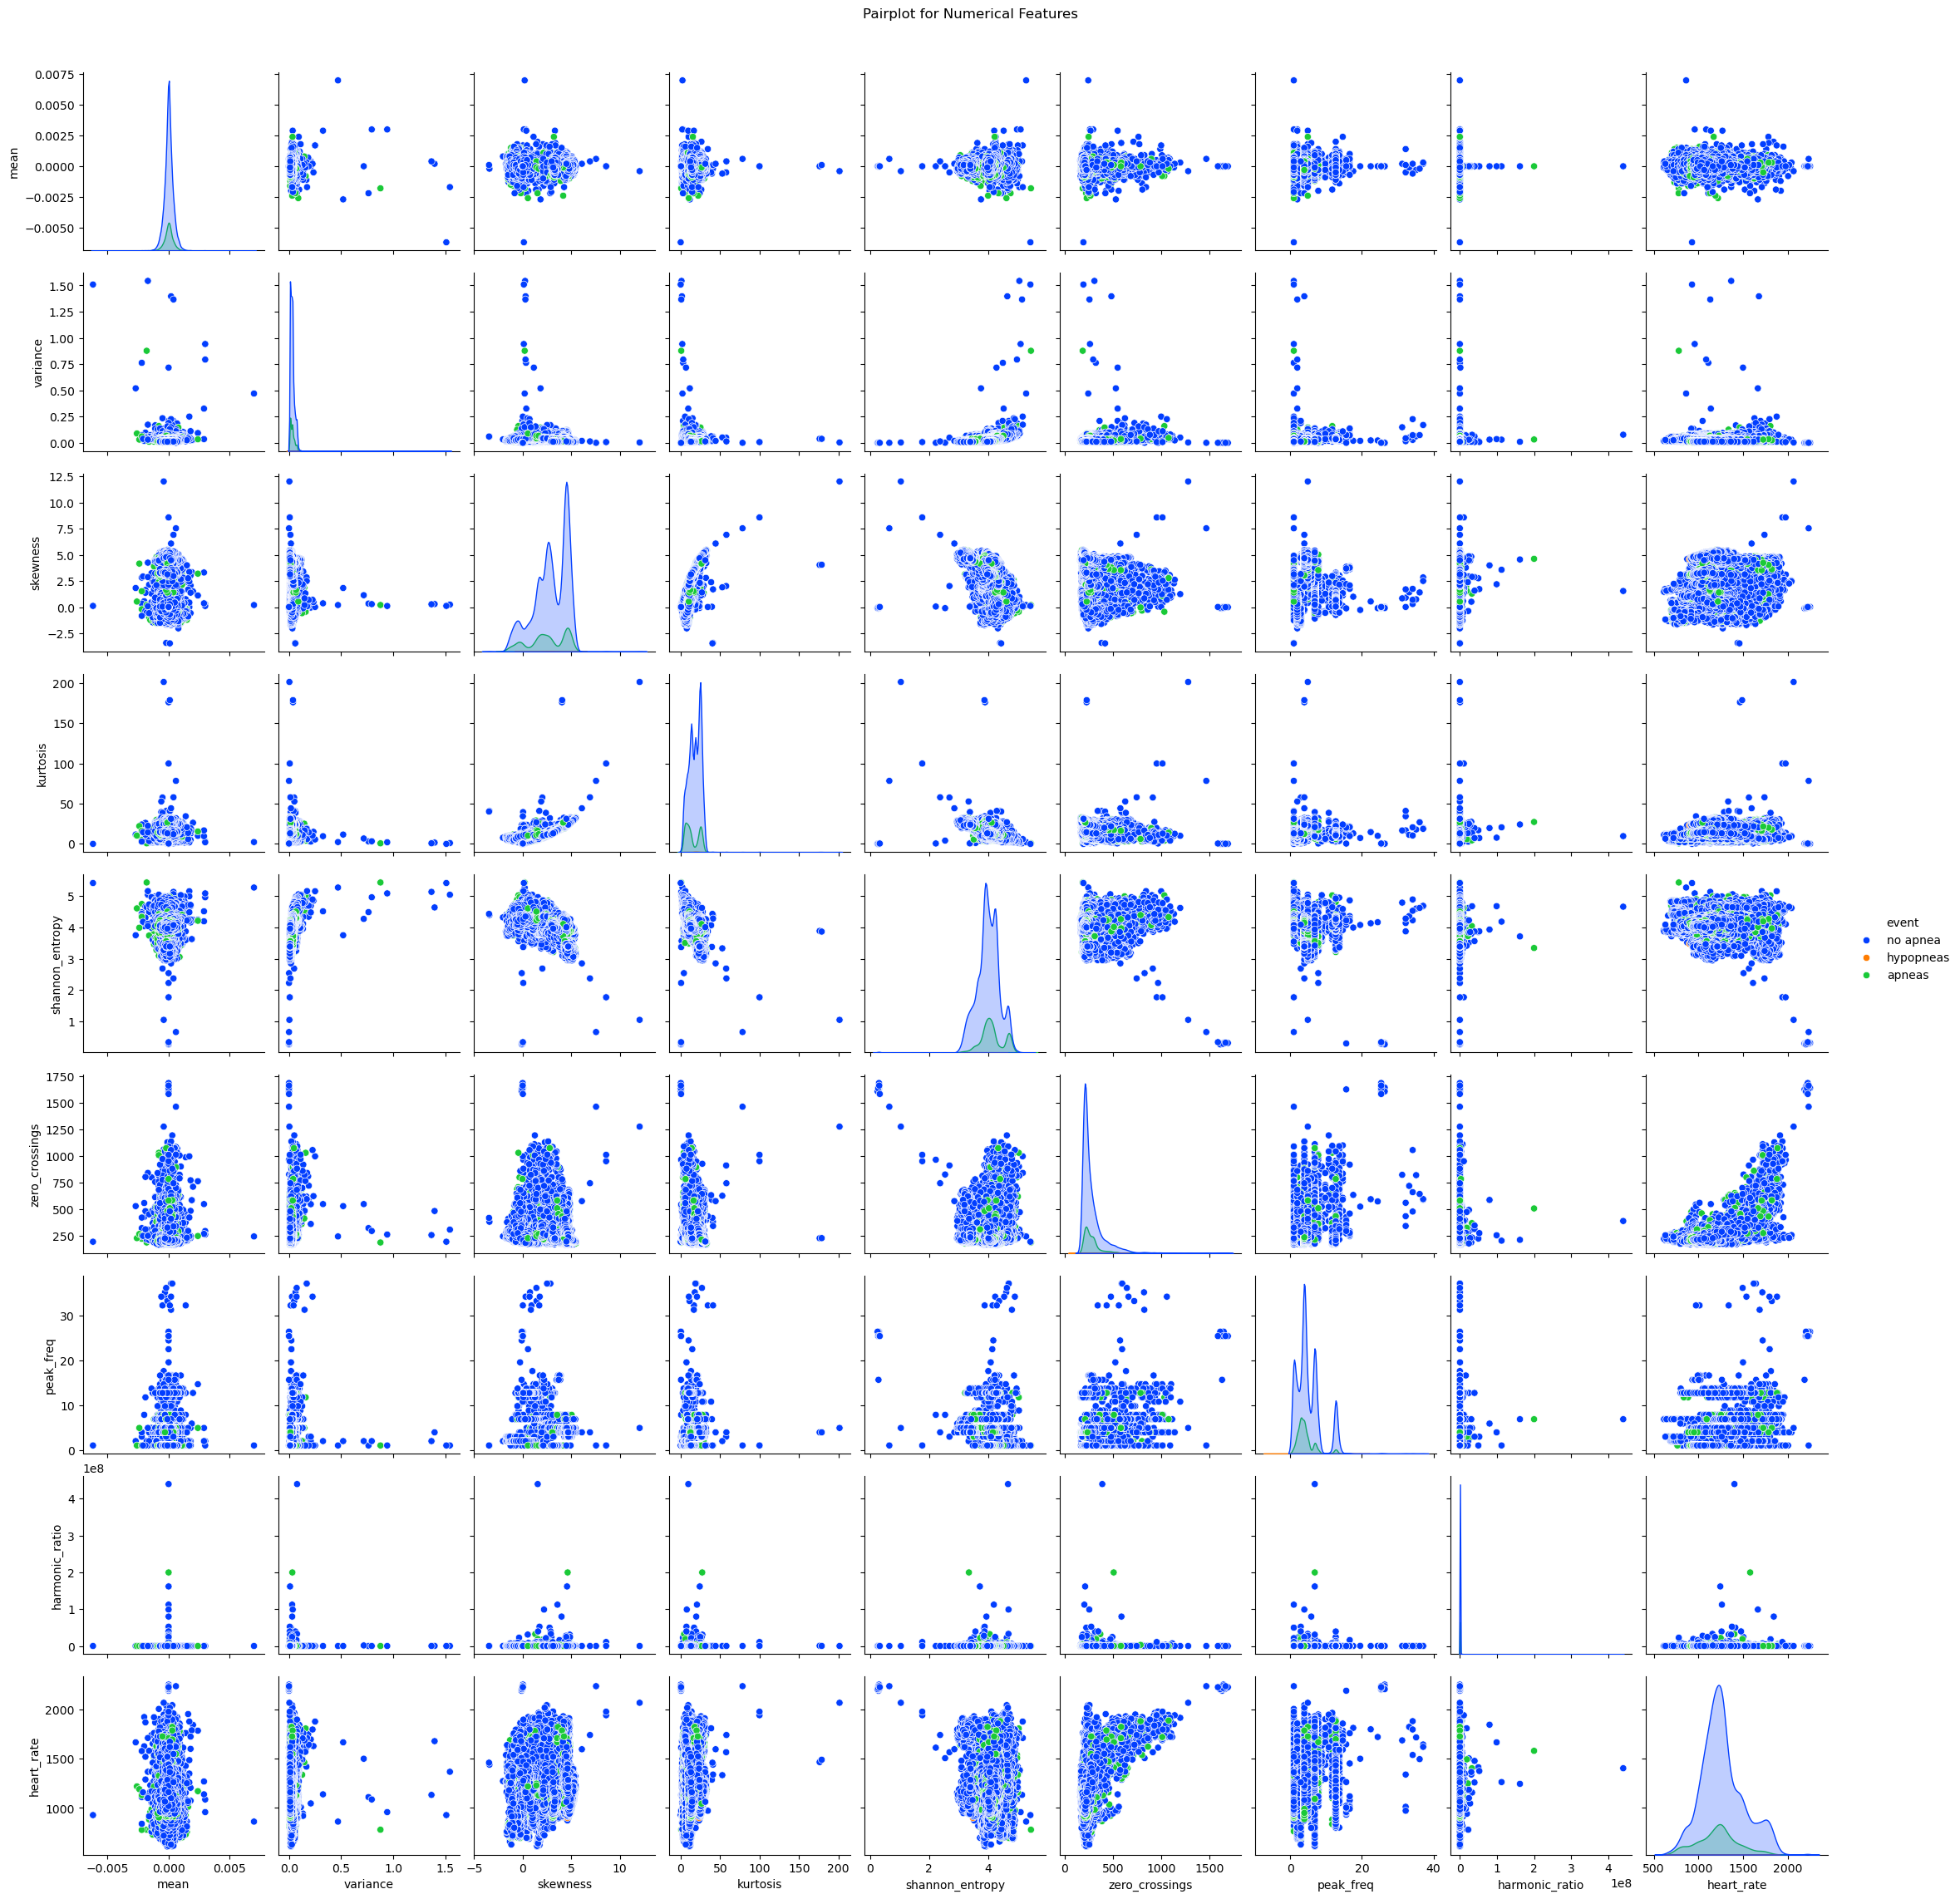

In [19]:
def multivariate_analysis(df, target_column='event', save_path='./plots/'):
    """
    Perform multivariate analysis:
    - Pairplots for numerical features with respect to the target.
    
    Parameters:
    df (DataFrame): The input DataFrame.
    target_column (str): The column to be used as the target variable (default 'event').
    save_path (str): Directory path to save the plots (default './plots/').
    """
    
    # Set a bright color palette
    sns.set_palette("bright")  # Brighter colors for the plot

    # Create a directory to save plots 
    import os
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Pairplot for numerical features
    numerical_columns = df.select_dtypes(include=['float64']).columns
    pairplot = sns.pairplot(df, vars=numerical_columns, hue=target_column, diag_kind="kde")
    plt.suptitle('Pairplot for Numerical Features', y=1.02)
    pairplot.savefig(f'{save_path}pairplot_numerical_features.png')  # Save the pairplot
    plt.show()

# Perform multivariate analysis with the target column 'event'
multivariate_analysis(df_features, target_column='event')


This pairplot visualization reveals several interesting patterns and relationships between numerical features in the dataset. The diagonal shows the distribution of individual variables through histograms, while the scatter plots show pairwise relationships between different variables. There appear to be some clear correlations between certain variables as indicated by linear or curved patterns in several scatter plots, while other variable pairs show more dispersed relationships. Some distributions appear to be right-skewed (having a longer tail on the right side), while others show more normal or multimodal distributions. The density of points in various regions of the scatter plots suggests potential clusters or groupings in the data, which could be valuable for understanding underlying patterns or segments in whatever phenomenon this data represents. The plot suggests a rich dataset with complex interactions between variables that would benefit from further statistical analysis to uncover deeper insights.

## Correlation Analysis

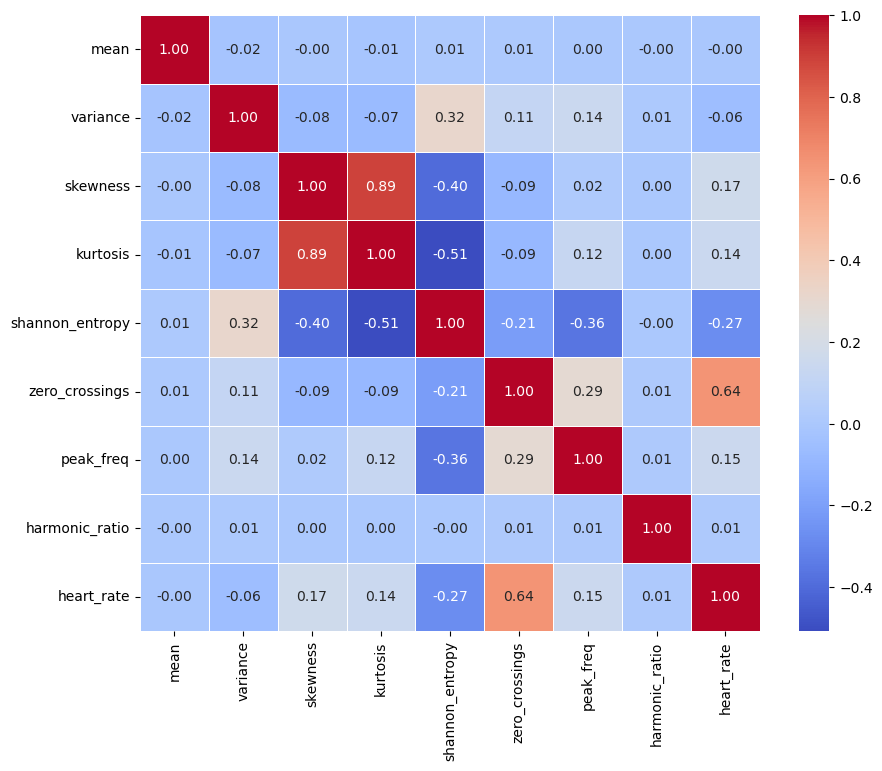

In [20]:
def correlation_analysis_save_and_display(df, save_dir='correlation_plots'):
    """Perform correlation analysis, display plots, and save them."""
    os.makedirs(save_dir, exist_ok=True)

    # Plot the correlation matrix as a heatmap
    numerical_columns = df.select_dtypes(include=['float64']).columns
    correlation_matrix = df[numerical_columns].corr()
    correlation_fig = plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    correlation_fig.savefig(os.path.join(save_dir, 'correlation_matrix.png'))  # Save the correlation matrix heatmap
    plt.show()  # Display the heatmap

# Perform correlation analysis: save and display plots
correlation_analysis_save_and_display(df_features)


This correlation matrix reveals several notable relationships among the features analyzed: there's a strong positive correlation (0.89) between skewness and kurtosis, suggesting similar distributional characteristics, while zero_crossings and heart_rate show a moderate positive correlation (0.64). Shannon entropy exhibits moderate negative correlations with both skewness (-0.40) and kurtosis (-0.51), indicating that as the data becomes more skewed or peaked, its entropy tends to decrease. Most other feature pairs show weak or negligible correlations (values close to 0), with mean and variance showing particularly low correlations with other features, suggesting they capture independent aspects of the data. The presence of both positive and negative correlations, ranging from strong to weak, indicates a complex interplay between these audio-related features, with some measures being closely related while others remain relatively independent.


# 1. HMM Model Architecture



In [21]:
class SleepApneaHMM:
    def __init__(self):
        self.n_states = 6
        self.model = hmm.GaussianHMM(
            n_components=self.n_states,
            covariance_type="tied",  # tied covariance
            n_iter=2000,  # Increase iterations
            random_state=42,
            tol=1e-3,  # Relaxed tolerance
            init_params="kmeans"  # Better initialization
        )
        self.scaler = StandardScaler()
        self.event_encoder = LabelEncoder()
        self.stage_encoder = LabelEncoder()
        self.state_event_mapping = None



The class `SleepApneaHMM` defines a Hidden Markov Model (HMM) for detecting sleep apnea, with the following components:

- **n_states**: The number of hidden states, set to 6, which corresponds to various sleep stages.
- **GaussianHMM**: The Gaussian HMM model is initialized with the following parameters:
  - `n_components=self.n_states`: The number of hidden states is set to 6.
  - `covariance_type="tied"`: The model assumes tied covariance across states, making it suitable for signals with similar covariance.
  - `n_iter=2000`: The model will run for 2000 iterations, allowing it to converge better.
  - `random_state=42`: The random state ensures reproducibility of results.
  - `tol=1e-3`: A tolerance level to stop optimization early if changes are small enough.
  - `init_params="kmeans"`: The initialization of the model parameters is done using K-means clustering, which is often more effective for this type of model.
- **scaler**: A `StandardScaler` instance is used to normalize the features, ensuring that they have a mean of 0 and a standard deviation of 1.
- **event_encoder and stage_encoder**: Label encoders to convert categorical event and sleep stage labels into numeric values.
- **state_event_mapping**: A placeholder for mapping the hidden states of the HMM to corresponding sleep events and stages.

This structure is designed to process ECG signals and associated data to detect sleep apnea events by learning from hidden states and transitions between sleep stages and apnea occurrences.

# 2. Learning Process

In [22]:
def train_hmm(model, data_path):
    df = pd.read_csv(data_path)
    
    feature_cols = ['mean', 'variance', 'skewness', 'kurtosis', 'shannon_entropy', 'zero_crossings', 
             'peak_freq', 'harmonic_ratio', 'heart_rate']
    X = df[feature_cols].values
    events = model.event_encoder.fit_transform(df['event'])
    stages = model.stage_encoder.fit_transform(df['sleep_stage'])
    X_scaled = model.scaler.fit_transform(X)
    
    # Split the dataset
    X_train, X_test, events_train, events_test, stages_train, stages_test = train_test_split(
        X_scaled, events, stages, test_size=0.2, random_state=42
    )
    
    # Balance the dataset using SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, events_train_balanced = smote.fit_resample(X_train, events_train)
    
    print("Starting HMM training process...")
    model.model.fit(X_train_balanced)
    
    # Learn state-event mapping
    predicted_states = model.model.predict(X_train_balanced)
    state_event_mapping = np.zeros((model.n_states, len(set(events_train_balanced))))
    for state in range(model.n_states):
        state_mask = predicted_states == state
        if np.any(state_mask):
            event_counts = np.bincount(events_train_balanced[state_mask], 
                                       minlength=len(set(events_train_balanced)))
            state_event_mapping[state] = event_counts / np.sum(event_counts)
    
    model.state_event_mapping = state_event_mapping
    print("Training completed.")
    print(f"Model score: {model.model.score(X_train_balanced)}")
    
    return X_test, events_test, stages_test


The `train_hmm` function trains the Hidden Markov Model (HMM) for sleep apnea detection, following these steps:

1. **Data Loading and Preprocessing**:
   - It loads the dataset from a CSV file using `pandas.read_csv()`.
   - The features (mean, variance, skewness, kurtosis, etc.) are selected for training.
   - The `event` and `sleep_stage` columns are encoded into numerical values using the `LabelEncoder` from the model object.
   - The feature matrix `X` is scaled using `StandardScaler`.

2. **Dataset Splitting**:
   - The dataset is split into training and testing sets with 80% for training and 20% for testing using `train_test_split()`.

3. **Balancing the Data**:
   - The training data is balanced using **SMOTE** (Synthetic Minority Over-sampling Technique) to deal with class imbalances in the `event` labels.

4. **HMM Training**:
   - The model is trained using the balanced training data (`X_train_balanced`), and the HMM model is fitted on it.
   - After training, the predicted states for the training data are used to create a mapping (`state_event_mapping`) between the hidden states of the model and the corresponding events. This mapping is based on the frequency of events within each state.

5. **Model Evaluation**:
   - The model's training score is printed to indicate how well the model has fit the training data.

6. **Return**:
   - The function returns the test set (`X_test`, `events_test`, `stages_test`) for later evaluation.

The function prepares the dataset, trains the HMM model, and generates a state-event mapping to interpret the hidden states in terms of actual events and sleep stages. This approach leverages machine learning to detect patterns in sleep apnea events more effectively.

# 3. Evaluation Process

In [23]:

def evaluate_hmm(model, X_test, true_events, true_stages):
    print("\nStarting evaluation process...")
    predicted_states = model.model.predict(X_test)
    predicted_events = np.array([np.argmax(model.state_event_mapping[state]) 
                                  for state in predicted_states])
    
    print("\nRespiration Event Classification Report:")
    print(classification_report(
        true_events, 
        predicted_events,
        target_names=model.event_encoder.classes_,
        zero_division=0  # Handle undefined metrics
    ))
    
    event_accuracy = accuracy_score(true_events, predicted_events)
    print(f"Event Classification Accuracy: {event_accuracy * 100:.2f}%")
    
    event_cm = confusion_matrix(true_events, predicted_events)
    plt.figure(figsize=(10, 8))
    sns.heatmap(event_cm, 
                annot=True,
                fmt='d',
                xticklabels=model.event_encoder.classes_,
                yticklabels=model.event_encoder.classes_)
    plt.title('Confusion Matrix - Respiration Events')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig("confusion_matrix_respiration_events.png")  # Save plot
    plt.show()
    
    return predicted_states, predicted_events


The function `evaluate_hmm` is designed to evaluate the performance of a Hidden Markov Model (HMM) used for respiration event classification. Here’s a breakdown of what the code does:

1. **Predictions**:
   - It uses the trained HMM model to predict the states (`predicted_states`) for the test data (`X_test`).
   - The predicted states are mapped to respiration events using the state-event mapping matrix (`model.state_event_mapping`). The event corresponding to each state is the one with the highest probability.

2. **Classification Report**:
   - The `classification_report` from `sklearn.metrics` is used to generate a detailed report of precision, recall, f1-score, and support for each event class.
   - It also uses `target_names=model.event_encoder.classes_` to display the class labels as defined in the `event_encoder`.
   - `zero_division=0` ensures that when there are divisions by zero (e.g., when a class has no predictions), the result will be 0 instead of an error.

3. **Event Classification Accuracy**:
   - The accuracy score is computed using `accuracy_score` from `sklearn.metrics`, and it shows how well the predicted events match the true events.

4. **Confusion Matrix**:
   - A confusion matrix is generated to show how well the model is classifying each event. The confusion matrix is visualized as a heatmap using `seaborn.heatmap`, with the x and y axes representing the true and predicted event labels, respectively.

5. **Return Values**:
   - The function returns the `predicted_states` and `predicted_events`, which can be used for further analysis or evaluation.



# 4. Decoding Process

In [24]:
def visualize_transition_matrix_with_percentage(model, stage_labels):
    """
    Visualize the transition matrix from the trained HMM in percentages.

    Args:
        model: The SleepApneaHMM model containing the GaussianHMM instance.
        stage_labels: A list of labels for the stages, corresponding to the states.
    """
    # Extract the transition matrix from the trained HMM
    transition_matrix = model.model.transmat_

    # Convert raw transition counts into percentage values
    transition_matrix_percentage = transition_matrix / transition_matrix.sum(axis=1, keepdims=True) * 100

    # Create a heatmap with percentage values
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        transition_matrix_percentage,
        annot=True,
        fmt='.2f',  # Format as percentage with two decimal points
        cmap="Blues",  # Choose color map for better visibility
        xticklabels=stage_labels,
        yticklabels=stage_labels,
        cbar_kws={'label': 'Transition Probability (%)'}
    )
    plt.title('State Transition Probabilities (in %)')
    plt.ylabel('From Stage')
    plt.xlabel('To Stage')
    plt.savefig("state_transition_probabilities.png")  # Save plot
    plt.show()


In [25]:
def decode_sleep_stages(model, X_test, predicted_states, true_stages):
    print("\nStarting decoding process for sleep stages...")
    viterbi_states = model.model.predict(X_test)
    
    print("\nSleep Stage Classification Report:")
    print(classification_report(
        true_stages,
        viterbi_states,
        target_names=model.stage_encoder.classes_,
        zero_division=0  # Handle undefined metrics
    ))
    
    stage_accuracy = accuracy_score(true_stages, viterbi_states)
    print(f"Sleep Stage Classification Accuracy: {stage_accuracy * 100:.2f}%")
    
    stage_cm = confusion_matrix(true_stages, viterbi_states)
    plt.figure(figsize=(10, 8))
    sns.heatmap(stage_cm,
                annot=True,
                fmt='d',
                xticklabels=model.stage_encoder.classes_,
                yticklabels=model.stage_encoder.classes_)
    plt.title('Confusion Matrix - Sleep Stages')
    plt.ylabel('True Stage')
    plt.xlabel('Predicted Stage')
    plt.savefig("confusion_matrix_sleep_stages.png")  # Save plot
    plt.show()
    
    transition_matrix = model.model.transmat_
    plt.figure(figsize=(10, 8))
    sns.heatmap(transition_matrix,
                annot=True,
                fmt='.2f',
                xticklabels=model.stage_encoder.classes_,
                yticklabels=model.stage_encoder.classes_)
    plt.title('State Transition Probabilities')
    plt.ylabel('From Stage')
    plt.xlabel('To Stage')
    plt.savefig("state_transition_probabilities_matrix.png")  # Save plot
    plt.show()

    # Integrating the visualize_transition_matrix_with_percentage function

    
    
    # Now call the visualization function here:
    stage_labels = model.stage_encoder.classes_  # Using stage labels from the model's encoder
    visualize_transition_matrix_with_percentage(model, stage_labels)
    
    return viterbi_states


The `decode_sleep_stages` function evaluates the sleep stage predictions made by the Hidden Markov Model (HMM) for a given test dataset (`X_test`). Here's a detailed breakdown of its functionality:

1. **Viterbi Decoding**:
   - The function uses the `predict()` method of the HMM model to obtain the most likely sequence of hidden states (`viterbi_states`) for the given input features (`X_test`). The Viterbi algorithm is typically used for this purpose in HMMs, which provides the optimal path of states.

2. **Classification Report**:
   - The function uses `classification_report` from `sklearn.metrics` to generate a detailed report on the model's performance in classifying sleep stages.
   - The `target_names=model.stage_encoder.classes_` ensures that the class labels are displayed correctly based on the encoder.
   - The `zero_division=0` argument ensures that if a class has no predictions, the result will be set to zero instead of causing an error.

3. **Accuracy**:
   - The accuracy of the sleep stage predictions is computed using `accuracy_score`. It calculates the proportion of correct classifications in the test set.

4. **Confusion Matrix**:
   - A confusion matrix is generated using `confusion_matrix` from `sklearn.metrics` to visualize the performance of the model in classifying each sleep stage.
   - The confusion matrix is then displayed as a heatmap using `seaborn.heatmap`.

5. **Transition Matrix**:
   - The transition matrix (`model.model.transmat_`) is extracted from the HMM, which indicates the probabilities of transitioning from one sleep stage to another. This matrix is visualized as a heatmap to understand how the model transitions between different sleep stages.

6. **Return Values**:
   - The function returns the sequence of predicted sleep stages (`viterbi_states`), which can be used fo the model's performance.

# 5. Main Execution

1. Initializing HMM Model Architecture...

2. Starting Learning Process...
Starting HMM training process...
Training completed.
Model score: -349838.05022452504

3. Starting Evaluation Process...

Starting evaluation process...

Respiration Event Classification Report:
              precision    recall  f1-score   support

      apneas       0.22      0.50      0.31       649
   hypopneas       0.01      0.83      0.02         6
    no apnea       0.86      0.52      0.65      3451

    accuracy                           0.52      4106
   macro avg       0.37      0.62      0.33      4106
weighted avg       0.76      0.52      0.60      4106

Event Classification Accuracy: 51.92%


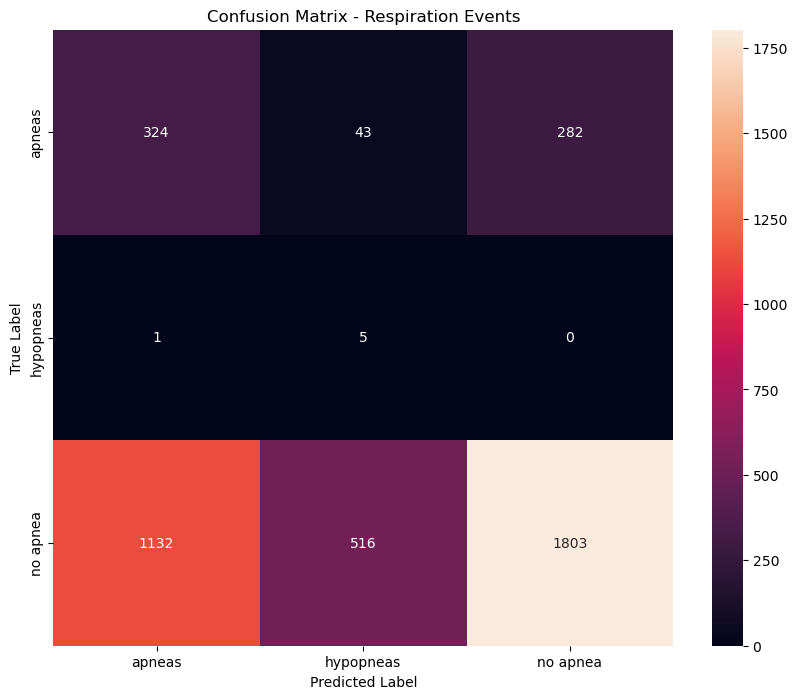


4. Starting Decoding Process...

Starting decoding process for sleep stages...

Sleep Stage Classification Report:
              precision    recall  f1-score   support

       Awake       0.36      0.22      0.28      1658
         REM       0.04      0.02      0.03       291
     Stage 1       0.11      0.07      0.09       689
     Stage 2       0.11      0.01      0.02      1325
     Stage 3       0.04      0.18      0.07        99
     Stage 4       0.01      0.36      0.02        44

    accuracy                           0.11      4106
   macro avg       0.11      0.14      0.08      4106
weighted avg       0.21      0.11      0.13      4106

Sleep Stage Classification Accuracy: 11.40%


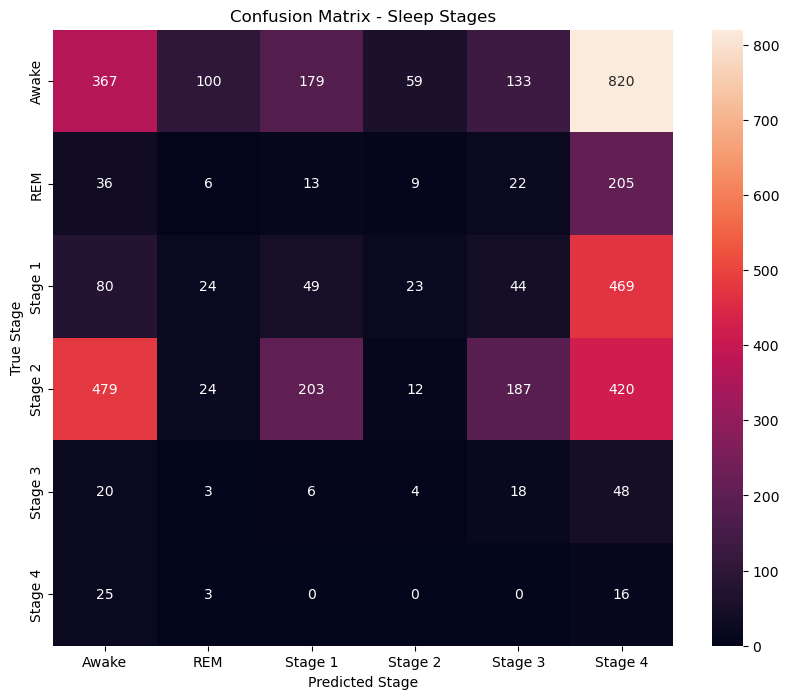

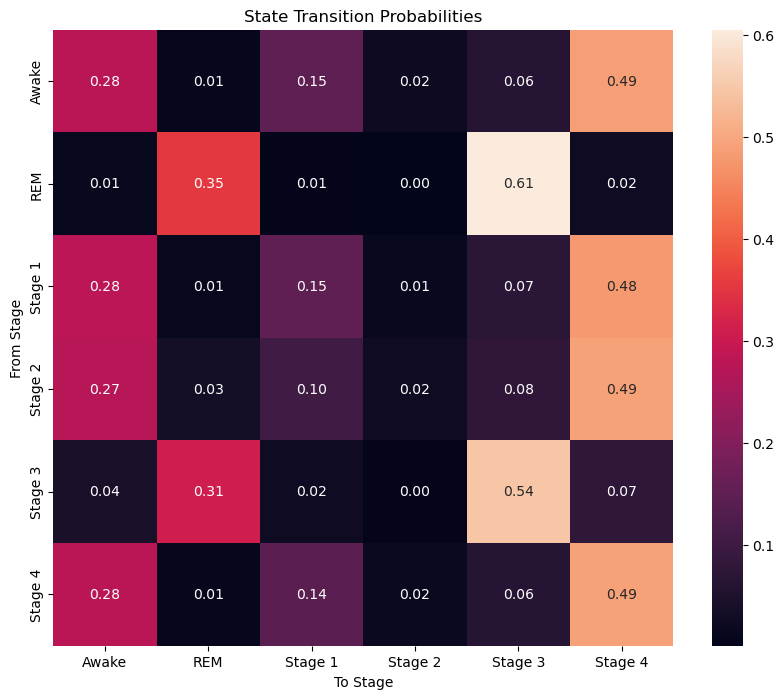

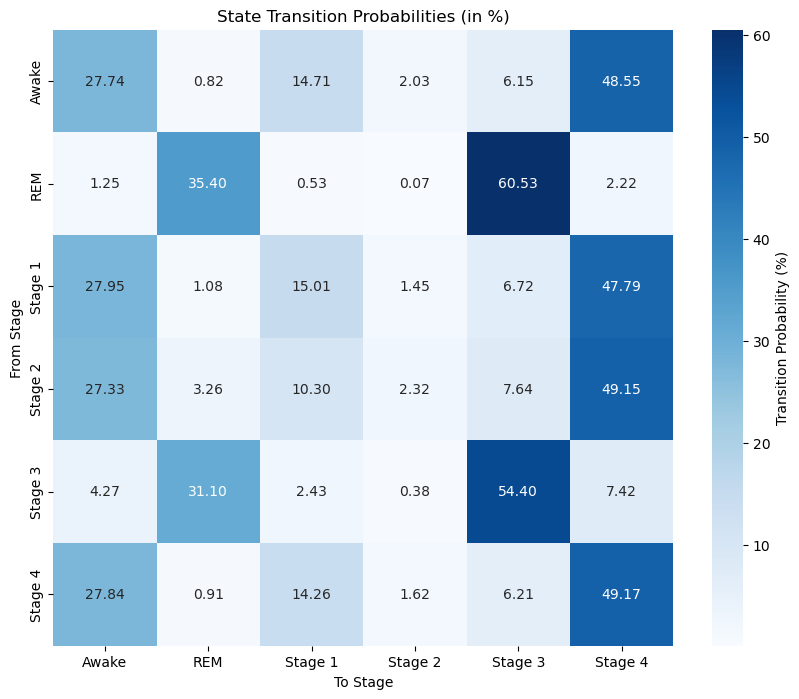


Example Sequence (first 10 windows):
True Events: ['no apnea' 'no apnea' 'no apnea' 'no apnea' 'no apnea' 'apneas'
 'no apnea' 'no apnea' 'no apnea' 'no apnea']
Predicted Events: ['no apnea' 'hypopneas' 'hypopneas' 'hypopneas' 'hypopneas' 'no apnea'
 'no apnea' 'hypopneas' 'apneas' 'apneas']
True Stages: ['Stage 2' 'Awake' 'Stage 1' 'Stage 3' 'Awake' 'Stage 2' 'Stage 1'
 'Stage 2' 'Stage 1' 'Stage 1']
Predicted Stages: ['Stage 4' 'Stage 3' 'REM' 'REM' 'Stage 3' 'Stage 4' 'Stage 4' 'Stage 3'
 'Awake' 'Stage 1']


In [26]:
def main():
    print("1. Initializing HMM Model Architecture...")
    model = SleepApneaHMM()
    
    print("\n2. Starting Learning Process...")
    X_test, events_test, stages_test = train_hmm(model, 'processed_features_with_annotations.csv')
    
    print("\n3. Starting Evaluation Process...")
    predicted_states, predicted_events = evaluate_hmm(model, X_test, events_test, stages_test)
    
    print("\n4. Starting Decoding Process...")
    viterbi_states = decode_sleep_stages(model, X_test, predicted_states, stages_test)
    
    print("\nExample Sequence (first 10 windows):")
    print("True Events:", model.event_encoder.inverse_transform(events_test[:10]))
    print("Predicted Events:", model.event_encoder.inverse_transform(predicted_events[:10]))
    print("True Stages:", model.stage_encoder.inverse_transform(stages_test[:10]))
    print("Predicted Stages:", model.stage_encoder.inverse_transform(viterbi_states[:10]))

if __name__ == "__main__":
    main()


The main() function serves as an entry point for running the entire workflow: initializing the HMM model, training it, evaluating its performance, and decoding sleep stages. It follows a logical flow of operations, and here's a brief breakdown of what happens:

Initializing the HMM Model:

The SleepApneaHMM class is instantiated, initializing the HMM model with 6 hidden states and other configurations.

Training the Model:
The model is trained using the train_hmm() function, where features and labels are extracted and split into training and testing sets. The dataset is balanced using SMOTE to mitigate class imbalance, and the HMM model is trained.

Evaluation:
The evaluate_hmm() function evaluates the trained model on the test data, calculating performance metrics such as accuracy and confusion matrices for event classification.

Decoding Sleep Stages:
The decode_sleep_stages() function decodes the predicted states from the HMM into actual sleep stages and evaluates the stage classification performance.

Displaying Results:
Finally, the script prints the true and predicted events and stages for the first 10 windows, which will help visualize how the model is performing.

## Inference on Results

**HMM Model Training:**

The model achieved a log-likelihood score of approximately -349838, which indicates the fit of the model to the training data. While this score is negative (as expected for log-likelihood), its significance should be interpreted in context with data complexity and expected model performance.

## Respiration Event Classification:

**Accuracy:** The event classification accuracy is 51.92%, indicating the model predicts events slightly better than random guessing (baseline would be around 33.33% given three classes).

**Precision & Recall:**

- For "apneas," the model shows 22% precision and 50% recall, meaning it identifies many true apneas but also produces a considerable number of false positives.

- For "no apnea," the model performs relatively well with 86% precision but only 52% recall, suggesting it correctly identifies most instances as "no apnea" when predicted, but misses several true "no apnea" events.

- For "hypopneas," the model's performance is poor, with 1% precision but 83% recall, indicating it misclassifies most events as hypopneas when this label is predicted.

**Weighted Average:**

The weighted average precision (76%), recall (52%), and F1-score (60%) suggest the model heavily favors the dominant class, "no apnea," while struggling with minority classes like "hypopneas."



**Confusion Matrix**

The model shows strong performance in identifying the No Apnea class with 1,803 correct predictions. However, significant confusion exists between Apneas and No Apnea, indicating overlapping features. The Hypopneas class is poorly classified, with most instances misclassified into other classes, suggesting the need for better feature extraction and balancing.

## Sleep Stage Decoding:

Accuracy: The sleep stage decoding accuracy is 11.40%, indicating poor performance in predicting the correct sleep stage from the data.

**Precision & Recall:**
- "Awake" stages achieved a 36% precision but only 22% recall, meaning the model frequently predicts awake stages when true but fails to identify most actual awake instances.
- "Stage 4" has an extremely low precision of 1% but a high recall of 36%, implying the model overpredicts this stage but does capture some true occurrences.
- The other stages (REM, Stage 1, Stage 2, Stage 3) show very low precision and recall, reflecting significant challenges in correctly distinguishing between these stages.


**Weighted Average:**
The weighted averages (precision 21%, recall 11%) underscore the model's limited ability to generalize and effectively classify sleep stages from the given data.


**Confusion Matrix**

The model performs well for the Awake and Stage 2 classes, with 367 and 420 correct predictions, respectively. However, REM, Stage 1, Stage 3, and Stage 4 exhibit poor classification accuracy, with significant overlap between stages. High misclassification rates indicate insufficient model generalization across sleep stages.


**State Transition Probabilities Matrix**
Transitions between sleep stages are uneven, with a high probability of moving from Awake → Stage 4 (49%) and REM → Stage 3 (61%). Stable states like Stage 3 and Stage 4 reflect high self-transition probabilities, while imbalanced transitions suggest room for improvement in modeling time-series dependencies.


## Example Predictions:

**Event predictions:** The model correctly predicts the "no apnea" event in several instances but misclassifies others as "hypopneas" or "apneas."

**Sleep stage predictions:** There is substantial disagreement between true and predicted stages. For instance, "Stage 2" is often misclassified as "Stage 4," and "REM" is poorly captured.


## Conclusion

The model demonstrates basic capability in classifying respiration events with moderate accuracy but struggles with imbalanced classes and complex dynamics, as evident in the low performance for rare events like hypopneas and sleep stages. The significant gap between training success and evaluation results suggests overfitting, while the poor sleep stage classification highlights the need for more robust features and advanced modeling techniques. Improvements in data balancing, feature engineering, and model architecture are essential to enhance its clinical applicability and overall predictive performance.

## Limitations

The current model faces several limitations that impact its performance and clinical utility. One key challenge is the imbalanced dataset, where rare events like hypopneas and underrepresented sleep stages such as Stage 3 and REM are poorly predicted. This is compounded by the model’s inability to capture complex physiological relationships, as the Gaussian HMM, though effective for basic temporal patterns, lacks the sophistication needed for intricate sleep dynamics. The low precision and recall across most sleep stages suggest that the feature set, which includes statistical and frequency-domain measures, may not fully encapsulate the nuanced variations in sleep physiology. Additionally, overfitting during training indicates that the model is not generalizing well to new data, limiting its effectiveness for clinical application.

In preparing the data, limitations also arise. The process of parsing sleep study annotation files to categorize sleep stages and apnea events introduces potential inaccuracies, especially when dealing with missing or unknown stages. While post-processing attempts to fill gaps in stage information, it may still lead to misclassifications or incomplete stage transitions. Furthermore, the approach of dividing data into overlapping windows and selecting the most frequent event and stage within each window can result in oversimplification, as this method may fail to capture subtle shifts in sleep patterns and apnea events. These data preparation challenges further affect the model’s ability to reliably classify events and stages.

## Future Scope

Future improvements can address these challenges through multiple avenues. Incorporating advanced feature extraction techniques, such as deep neural network embeddings, can provide richer representations of the physiological data. Exploring hybrid models that combine HMMs with deep learning architectures, such as LSTMs or GRUs, may enhance the model’s capacity to capture temporal dependencies and non-linear relationships. Addressing data imbalance through advanced augmentation techniques, like GAN-generated synthetic samples, can improve rare event classification. Furthermore, fine-tuning the HMM’s architecture, experimenting with different covariance types, and optimizing hyperparameters can lead to better performance. Incorporating multimodal data, such as EEG and respiratory signals, could yield a more holistic understanding of sleep patterns and improve classification accuracy.


## Generalization

For broader applicability, the model requires validation on larger, more diverse datasets spanning various demographics and clinical conditions. Integration of multimodal data, such as EEG, ECG, and respiratory signals, may improve robustness and ensure the model performs reliably in real-world settings. For real-world deployment, the model must demonstrate robust generalization across diverse populations, including different age groups, genders, and clinical conditions. This can be achieved by training and validating the model on larger, more diverse datasets sourced from multiple centers. Regularization techniques, cross-validation, and domain adaptation methods can ensure better performance across unseen data. By integrating multimodal data and addressing dataset heterogeneity, the model could achieve clinical-grade reliability, paving the way for its use in sleep studies, wearable devices, and personalized sleep therapy applications.